In [1]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Load the dataset
dataset = torch.load("HAM10000Skin_Cancer_Balanced.pt")

# Extract images and metadata
images = dataset["images"]
metadata = dataset["metadata"]

# Extract labels (assume dx is stored in the first column of metadata)
labels = metadata[:, 0].long()

# Create a DataFrame for clinical data (excluding labels)
clinical_data = pd.DataFrame(metadata[:, 1:].numpy(), columns=[
    f"clinical_{i}" for i in range(1, metadata.size(1))
])

classnames = classname = [
    "Benign lesions of the keratosis",
    "Basal cell carcinoma",
    "Dermatofibroma",
    "Melanoma",
    "Melanocylabels",
    "tic nevi",
    "Vascular lesions",
    "Actinic keratoses"
]
label_dict = {abbr: name for abbr, name in zip(["bkl", "bcc", "df", "mel", "nv", "vasc", "akiec"], classnames)}

# Split data into train and test
train_ratio = 0.85
train_size = int(train_ratio * len(images))
test_size = len(images) - train_size

indices = torch.randperm(len(images)).tolist()  # Shuffle indices
train_indices, test_indices = indices[:train_size], indices[train_size:]

# Split data
X_train_images = images[train_indices]
X_test_images = images[test_indices]
X_train_clin = clinical_data.iloc[train_indices]
X_test_clin = clinical_data.iloc[test_indices]
y_train = labels[train_indices]
y_test = labels[test_indices]

# Create a custom dataset class
class SkinCancerDataset(Dataset):
    def __init__(self, images, clinical_data, labels):
        self.images = images
        self.clinical_data = clinical_data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "image": self.images[idx],
            "clinical_data": torch.tensor(self.clinical_data.iloc[idx].values, dtype=torch.float32),
            "label": self.labels[idx]
        }

# Create datasets
train_dataset = SkinCancerDataset(X_train_images, X_train_clin, y_train)
test_dataset = SkinCancerDataset(X_test_images, X_test_clin, y_test)

# Create dataloaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print summary
print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")
print(f"Classnames: {classnames}")
print(f"Label dictionary: {label_dict}")


C:\Users\dasad\AppData\Local\Temp\ipykernel_19396\3088060718.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load("HAM10000Skin_Cancer_Balanced.pt")


Train size: 17850, Test size: 3150
Classnames: ['Benign lesions of the keratosis', 'Basal cell carcinoma', 'Dermatofibroma', 'Melanoma', 'Melanocylabels', 'tic nevi', 'Vascular lesions', 'Actinic keratoses']
Label dictionary: {'bkl': 'Benign lesions of the keratosis', 'bcc': 'Basal cell carcinoma', 'df': 'Dermatofibroma', 'mel': 'Melanoma', 'nv': 'Melanocylabels', 'vasc': 'tic nevi', 'akiec': 'Vascular lesions'}


In [2]:
import torch
import torch.nn as nn

class WeightedResnet(nn.Module):
    def __init__(self, in_channels, num_classes, initial_res_weights=0.001):
        super(WeightedResnet, self).__init__()

        # Initialize res_weights as a learnable parameter
        self.res_weights = nn.Parameter(torch.tensor(initial_res_weights, dtype=torch.float32))

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True)
        )
        self.res1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
        )
        self.res2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
        )
        self.res3 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(0.1),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.res4 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Dropout(0.1),
            nn.BatchNorm2d(512)
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(0.1),
            nn.Linear(256, 512)
        )

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.res1(x) + self.res_weights * x

        x = self.conv3(x)
        x = self.res2(x) + self.res_weights * x

        x = self.conv4(x)
        x = self.res3(x) + self.res_weights * x

        x = self.conv5(x)
        x = self.res4(x) + self.res_weights * x

        x = self.classifier(x)
        x = self.softmax(x)

        return x


In [3]:
class ClinicalNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(ClinicalNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 256)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [4]:
import torch
import torch.nn as nn

class CrossAttentionFusion(nn.Module):
    def __init__(self, image_model, clinical_model, num_classes, image_feature_dim=512, clinical_feature_dim=256, num_layers=2, hidden_dim=1024):
        super(CrossAttentionFusion, self).__init__()
        self.image_model = image_model
        self.clinical_model = clinical_model

        # Enhanced Clinical Feature Projection
        self.clinical_projection = nn.Sequential(
            nn.Linear(clinical_feature_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, image_feature_dim)
        )

        # Multi-layer Cross Attention (Bidirectional)
        self.cross_attention_layers = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=image_feature_dim, num_heads=8, dropout=0.1)
            for _ in range(num_layers)
        ])
        self.cross_attention_layers_clinical = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=image_feature_dim, num_heads=8, dropout=0.1)
            for _ in range(num_layers)
        ])

        # Layer Normalization and Feedforward Networks
        self.norm1 = nn.LayerNorm(image_feature_dim)
        self.norm2 = nn.LayerNorm(image_feature_dim)
        self.norm3 = nn.LayerNorm(image_feature_dim)
        self.ffn = nn.Sequential(
            nn.Linear(image_feature_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, image_feature_dim)
        )

        # Dropout
        self.dropout = nn.Dropout(0.1)

        # Final classification
        self.fc = nn.Linear(image_feature_dim * 2, num_classes)

    def forward(self, image, clinical):
        # Extract features from both models
        image_features = self.image_model(image)  # [batch_size, image_feature_dim]
        clinical_features = self.clinical_model(clinical)  # [batch_size, clinical_feature_dim]

        # Project clinical features
        clinical_features = self.clinical_projection(clinical_features)  # [batch_size, image_feature_dim]

        # Normalize
        image_features = self.norm1(image_features)
        clinical_features = self.norm2(clinical_features)

        # Reshape for MultiheadAttention
        image_features = image_features.unsqueeze(0)  # [1, batch_size, image_feature_dim]
        clinical_features = clinical_features.unsqueeze(0)  # [1, batch_size, image_feature_dim]

        # Cross Attention (Bidirectional)
        for img2clin, clin2img in zip(self.cross_attention_layers, self.cross_attention_layers_clinical):
            # Image attends to clinical
            attended_image, _ = img2clin(image_features, clinical_features, clinical_features)
            image_features = self.norm1(image_features + self.dropout(attended_image))

            # Clinical attends to image
            attended_clinical, _ = clin2img(clinical_features, image_features, image_features)
            clinical_features = self.norm2(clinical_features + self.dropout(attended_clinical))

        # Reshape back to [batch_size, image_feature_dim]
        image_features = image_features.squeeze(0)
        clinical_features = clinical_features.squeeze(0)

        # Fusion: Concatenation of attended features
        fused_features = torch.cat([image_features, clinical_features], dim=-1)

        # Final classification
        output = self.fc(fused_features)  # [batch_size, num_classes]
        return output


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score

# Set the device for training (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models
num_classes = len(set(labels))
resnet_model = WeightedResnet(in_channels=3, num_classes=num_classes).to(device)
clinical_nn = ClinicalNN(input_dim=X_train_clin.shape[1], num_classes=num_classes).to(device)
combined_model = CrossAttentionFusion(image_model=resnet_model, clinical_model=clinical_nn, num_classes=num_classes).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(combined_model.parameters(), lr=0.001)

# DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Number of epochs
num_epochs = 500

# Lists to store metrics
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
test_recalls = []

# Training loop with tqdm and GPU support
for epoch in range(1, num_epochs + 1):
    combined_model.train()  # Set the model to training mode
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # Train the model
    for batch in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}", ncols=100):
        images = batch["image"].to(device)
        clinical_data = batch["clinical_data"].to(device)
        labels = batch["label"].to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = combined_model(images, clinical_data)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        running_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
    
    # Compute average training loss and accuracy for the epoch
    avg_train_loss = running_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train * 100

    # Evaluate on test set
    combined_model.eval()  # Set the model to evaluation mode
    running_test_loss = 0.0
    correct_test = 0
    total_test = 0
    all_labels, all_predictions = [], []
    
    with torch.no_grad():  # No need to compute gradients during evaluation
        for batch in test_loader:
            images = batch["image"].to(device)
            clinical_data = batch["clinical_data"].to(device)
            labels = batch["label"].to(device)

            # Forward pass
            outputs = combined_model(images, clinical_data)
            
            # Compute loss
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)

            # Collect labels and predictions for recall computation
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    # Compute average test loss and accuracy
    avg_test_loss = running_test_loss / len(test_loader)
    test_accuracy = correct_test / total_test * 100
    test_recall = recall_score(all_labels, all_predictions, average="macro") * 100

    # Store metrics for plotting
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    test_recalls.append(test_recall)

    # Print metrics
    print(f"Epoch {epoch}/{num_epochs}")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Test Recall: {test_recall:.2f}%")

    # Save checkpoint periodically
    if epoch % 10 == 0:
        torch.save(combined_model.state_dict(), f"checkpoint_epoch_{epoch}.pt")
        
    if test_accuracy > 98:
        break;


# Plot metrics
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 8))

# Loss curve
plt.subplot(3, 1, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Accuracy curve
plt.subplot(3, 1, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()

# Recall curve
plt.subplot(3, 1, 3)
plt.plot(epochs, test_recalls, label="Test Recall")
plt.xlabel("Epoch")
plt.ylabel("Recall (%)")
plt.title("Recall Curve")
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/500: 100%|████████████████████████████████████████████████| 279/279 [02:30<00:00,  1.86it/s]


Epoch 1/500
Train Loss: 1.8773, Train Accuracy: 26.35%
Test Loss: 2.1587, Test Accuracy: 23.27%, Test Recall: 23.33%


Epoch 2/500: 100%|████████████████████████████████████████████████| 279/279 [02:33<00:00,  1.82it/s]


Epoch 2/500
Train Loss: 1.9255, Train Accuracy: 20.38%
Test Loss: 1.9704, Test Accuracy: 14.92%, Test Recall: 14.29%


Epoch 3/500: 100%|████████████████████████████████████████████████| 279/279 [02:35<00:00,  1.79it/s]


Epoch 3/500
Train Loss: 1.9793, Train Accuracy: 14.39%
Test Loss: 1.9752, Test Accuracy: 13.75%, Test Recall: 14.29%


Epoch 4/500: 100%|████████████████████████████████████████████████| 279/279 [02:31<00:00,  1.84it/s]


Epoch 4/500
Train Loss: 1.9770, Train Accuracy: 14.02%
Test Loss: 1.9756, Test Accuracy: 14.44%, Test Recall: 14.29%


Epoch 5/500: 100%|████████████████████████████████████████████████| 279/279 [02:34<00:00,  1.80it/s]


Epoch 5/500
Train Loss: 1.9744, Train Accuracy: 13.84%
Test Loss: 1.9807, Test Accuracy: 13.84%, Test Recall: 14.29%


Epoch 6/500: 100%|████████████████████████████████████████████████| 279/279 [02:35<00:00,  1.79it/s]


Epoch 6/500
Train Loss: 1.9644, Train Accuracy: 15.14%
Test Loss: 1.9572, Test Accuracy: 14.00%, Test Recall: 14.29%


Epoch 7/500: 100%|████████████████████████████████████████████████| 279/279 [02:31<00:00,  1.84it/s]


Epoch 7/500
Train Loss: 1.9600, Train Accuracy: 14.40%
Test Loss: 1.9517, Test Accuracy: 14.92%, Test Recall: 14.29%


Epoch 8/500: 100%|████████████████████████████████████████████████| 279/279 [02:31<00:00,  1.84it/s]


Epoch 8/500
Train Loss: 1.9600, Train Accuracy: 14.07%
Test Loss: 1.9608, Test Accuracy: 14.44%, Test Recall: 14.29%


Epoch 9/500: 100%|████████████████████████████████████████████████| 279/279 [02:34<00:00,  1.81it/s]


Epoch 9/500
Train Loss: 1.9584, Train Accuracy: 14.56%
Test Loss: 1.9729, Test Accuracy: 13.75%, Test Recall: 14.29%


Epoch 10/500: 100%|███████████████████████████████████████████████| 279/279 [02:31<00:00,  1.84it/s]


Epoch 10/500
Train Loss: 1.9559, Train Accuracy: 14.17%
Test Loss: 1.9503, Test Accuracy: 14.60%, Test Recall: 14.29%


Epoch 11/500: 100%|███████████████████████████████████████████████| 279/279 [02:35<00:00,  1.79it/s]


Epoch 11/500
Train Loss: 1.9547, Train Accuracy: 14.17%
Test Loss: 1.9743, Test Accuracy: 15.75%, Test Recall: 15.84%


Epoch 12/500: 100%|███████████████████████████████████████████████| 279/279 [02:33<00:00,  1.82it/s]


Epoch 12/500
Train Loss: 1.9544, Train Accuracy: 14.27%
Test Loss: 1.9656, Test Accuracy: 14.60%, Test Recall: 14.29%


Epoch 13/500: 100%|███████████████████████████████████████████████| 279/279 [02:32<00:00,  1.84it/s]


Epoch 13/500
Train Loss: 1.9545, Train Accuracy: 14.00%
Test Loss: 1.9597, Test Accuracy: 14.44%, Test Recall: 14.29%


Epoch 14/500: 100%|███████████████████████████████████████████████| 279/279 [02:31<00:00,  1.84it/s]


Epoch 14/500
Train Loss: 1.9523, Train Accuracy: 14.43%
Test Loss: 1.9481, Test Accuracy: 14.44%, Test Recall: 14.29%


Epoch 15/500: 100%|███████████████████████████████████████████████| 279/279 [02:32<00:00,  1.83it/s]


Epoch 15/500
Train Loss: 1.9520, Train Accuracy: 14.23%
Test Loss: 1.9496, Test Accuracy: 14.60%, Test Recall: 14.29%


Epoch 16/500: 100%|███████████████████████████████████████████████| 279/279 [02:36<00:00,  1.78it/s]


Epoch 16/500
Train Loss: 1.9531, Train Accuracy: 14.08%
Test Loss: 1.9473, Test Accuracy: 14.44%, Test Recall: 14.29%


Epoch 17/500: 100%|███████████████████████████████████████████████| 279/279 [02:34<00:00,  1.81it/s]


Epoch 17/500
Train Loss: 1.9515, Train Accuracy: 14.58%
Test Loss: 1.9545, Test Accuracy: 14.44%, Test Recall: 14.29%


Epoch 18/500: 100%|███████████████████████████████████████████████| 279/279 [02:31<00:00,  1.84it/s]


Epoch 18/500
Train Loss: 1.9517, Train Accuracy: 13.95%
Test Loss: 1.9497, Test Accuracy: 14.60%, Test Recall: 14.29%


Epoch 19/500: 100%|███████████████████████████████████████████████| 279/279 [02:36<00:00,  1.78it/s]


Epoch 19/500
Train Loss: 1.9515, Train Accuracy: 14.63%
Test Loss: 1.9492, Test Accuracy: 14.00%, Test Recall: 14.29%


Epoch 20/500: 100%|███████████████████████████████████████████████| 279/279 [02:35<00:00,  1.79it/s]


Epoch 20/500
Train Loss: 1.9520, Train Accuracy: 14.16%
Test Loss: 1.9488, Test Accuracy: 14.44%, Test Recall: 14.29%


Epoch 21/500: 100%|███████████████████████████████████████████████| 279/279 [02:34<00:00,  1.81it/s]


Epoch 21/500
Train Loss: 1.9519, Train Accuracy: 13.96%
Test Loss: 1.9500, Test Accuracy: 14.00%, Test Recall: 14.29%


Epoch 22/500: 100%|███████████████████████████████████████████████| 279/279 [02:36<00:00,  1.78it/s]


Epoch 22/500
Train Loss: 1.9508, Train Accuracy: 13.92%
Test Loss: 1.9499, Test Accuracy: 14.44%, Test Recall: 14.29%


Epoch 23/500: 100%|███████████████████████████████████████████████| 279/279 [02:33<00:00,  1.81it/s]


Epoch 23/500
Train Loss: 1.9512, Train Accuracy: 13.98%
Test Loss: 1.9510, Test Accuracy: 14.44%, Test Recall: 14.29%


Epoch 24/500: 100%|███████████████████████████████████████████████| 279/279 [02:32<00:00,  1.83it/s]


Epoch 24/500
Train Loss: 1.9504, Train Accuracy: 14.54%
Test Loss: 1.9526, Test Accuracy: 13.75%, Test Recall: 14.29%


Epoch 25/500: 100%|███████████████████████████████████████████████| 279/279 [02:34<00:00,  1.80it/s]


Epoch 25/500
Train Loss: 1.9501, Train Accuracy: 14.38%
Test Loss: 1.9481, Test Accuracy: 13.75%, Test Recall: 14.29%


Epoch 26/500: 100%|███████████████████████████████████████████████| 279/279 [02:32<00:00,  1.83it/s]


Epoch 26/500
Train Loss: 1.9504, Train Accuracy: 13.86%
Test Loss: 1.9472, Test Accuracy: 14.00%, Test Recall: 14.29%


Epoch 27/500: 100%|███████████████████████████████████████████████| 279/279 [02:36<00:00,  1.79it/s]


Epoch 27/500
Train Loss: 1.9501, Train Accuracy: 14.22%
Test Loss: 1.9517, Test Accuracy: 13.84%, Test Recall: 14.29%


Epoch 28/500: 100%|███████████████████████████████████████████████| 279/279 [02:33<00:00,  1.81it/s]


Epoch 28/500
Train Loss: 1.9503, Train Accuracy: 14.34%
Test Loss: 1.9495, Test Accuracy: 14.00%, Test Recall: 14.29%


Epoch 29/500: 100%|███████████████████████████████████████████████| 279/279 [02:34<00:00,  1.81it/s]


Epoch 29/500
Train Loss: 1.9502, Train Accuracy: 14.25%
Test Loss: 1.9542, Test Accuracy: 13.75%, Test Recall: 14.29%


Epoch 30/500: 100%|███████████████████████████████████████████████| 279/279 [02:35<00:00,  1.79it/s]
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 30/500
Train Loss: 2.0784, Train Accuracy: 14.13%
Test Loss: 2.2791, Test Accuracy: 13.75%, Test Recall: 12.50%


Epoch 31/500: 100%|███████████████████████████████████████████████| 279/279 [02:33<00:00,  1.82it/s]


Epoch 31/500
Train Loss: 1.9615, Train Accuracy: 14.16%
Test Loss: 1.9561, Test Accuracy: 13.84%, Test Recall: 14.29%


Epoch 32/500: 100%|███████████████████████████████████████████████| 279/279 [02:36<00:00,  1.79it/s]


Epoch 32/500
Train Loss: 1.9523, Train Accuracy: 14.08%
Test Loss: 1.9467, Test Accuracy: 14.60%, Test Recall: 14.29%


Epoch 33/500: 100%|███████████████████████████████████████████████| 279/279 [02:34<00:00,  1.80it/s]


Epoch 33/500
Train Loss: 1.9559, Train Accuracy: 14.27%
Test Loss: 1.9517, Test Accuracy: 14.44%, Test Recall: 14.29%


Epoch 34/500: 100%|███████████████████████████████████████████████| 279/279 [02:37<00:00,  1.77it/s]


Epoch 34/500
Train Loss: 1.9508, Train Accuracy: 14.10%
Test Loss: 1.9504, Test Accuracy: 13.84%, Test Recall: 14.29%


Epoch 35/500: 100%|███████████████████████████████████████████████| 279/279 [02:33<00:00,  1.82it/s]


Epoch 35/500
Train Loss: 1.9513, Train Accuracy: 14.25%
Test Loss: 1.9506, Test Accuracy: 13.75%, Test Recall: 14.29%


Epoch 36/500: 100%|███████████████████████████████████████████████| 279/279 [02:33<00:00,  1.82it/s]


Epoch 36/500
Train Loss: 1.9538, Train Accuracy: 13.94%
Test Loss: 1.9482, Test Accuracy: 14.44%, Test Recall: 14.29%


Epoch 37/500: 100%|███████████████████████████████████████████████| 279/279 [02:35<00:00,  1.79it/s]


Epoch 37/500
Train Loss: 1.9512, Train Accuracy: 13.86%
Test Loss: 1.9565, Test Accuracy: 13.75%, Test Recall: 14.29%


Epoch 38/500: 100%|███████████████████████████████████████████████| 279/279 [02:36<00:00,  1.78it/s]


Epoch 38/500
Train Loss: 1.9516, Train Accuracy: 14.27%
Test Loss: 1.9508, Test Accuracy: 14.60%, Test Recall: 14.29%


Epoch 39/500: 100%|███████████████████████████████████████████████| 279/279 [02:34<00:00,  1.80it/s]


Epoch 39/500
Train Loss: 1.9542, Train Accuracy: 14.11%
Test Loss: 1.9484, Test Accuracy: 14.00%, Test Recall: 14.29%


Epoch 40/500: 100%|███████████████████████████████████████████████| 279/279 [02:38<00:00,  1.76it/s]


Epoch 40/500
Train Loss: 1.9514, Train Accuracy: 14.15%
Test Loss: 1.9491, Test Accuracy: 14.60%, Test Recall: 14.29%


Epoch 41/500: 100%|███████████████████████████████████████████████| 279/279 [02:32<00:00,  1.83it/s]


Epoch 41/500
Train Loss: 1.9512, Train Accuracy: 14.45%
Test Loss: 1.9496, Test Accuracy: 13.75%, Test Recall: 14.29%


Epoch 42/500: 100%|███████████████████████████████████████████████| 279/279 [02:35<00:00,  1.80it/s]


Epoch 42/500
Train Loss: 1.9499, Train Accuracy: 14.18%
Test Loss: 1.9491, Test Accuracy: 13.84%, Test Recall: 14.29%


Epoch 43/500: 100%|███████████████████████████████████████████████| 279/279 [02:34<00:00,  1.81it/s]


Epoch 43/500
Train Loss: 1.9513, Train Accuracy: 14.01%
Test Loss: 1.9507, Test Accuracy: 14.44%, Test Recall: 14.29%


Epoch 44/500: 100%|███████████████████████████████████████████████| 279/279 [02:35<00:00,  1.79it/s]


Epoch 44/500
Train Loss: 1.9509, Train Accuracy: 13.78%
Test Loss: 1.9481, Test Accuracy: 13.84%, Test Recall: 14.29%


Epoch 45/500: 100%|███████████████████████████████████████████████| 279/279 [02:39<00:00,  1.74it/s]


Epoch 45/500
Train Loss: 1.9512, Train Accuracy: 14.24%
Test Loss: 1.9511, Test Accuracy: 14.44%, Test Recall: 14.29%


Epoch 46/500: 100%|███████████████████████████████████████████████| 279/279 [02:33<00:00,  1.81it/s]


Epoch 46/500
Train Loss: 1.9512, Train Accuracy: 14.34%
Test Loss: 1.9493, Test Accuracy: 14.00%, Test Recall: 14.29%


Epoch 47/500: 100%|███████████████████████████████████████████████| 279/279 [02:34<00:00,  1.81it/s]


Epoch 47/500
Train Loss: 1.9531, Train Accuracy: 14.49%
Test Loss: 1.9518, Test Accuracy: 13.75%, Test Recall: 14.29%


Epoch 48/500: 100%|███████████████████████████████████████████████| 279/279 [02:35<00:00,  1.79it/s]


Epoch 48/500
Train Loss: 1.9512, Train Accuracy: 14.85%
Test Loss: 1.9558, Test Accuracy: 14.00%, Test Recall: 14.29%


Epoch 49/500: 100%|███████████████████████████████████████████████| 279/279 [02:32<00:00,  1.83it/s]


Epoch 49/500
Train Loss: 1.9505, Train Accuracy: 14.55%
Test Loss: 1.9538, Test Accuracy: 13.84%, Test Recall: 14.29%


Epoch 50/500: 100%|███████████████████████████████████████████████| 279/279 [02:35<00:00,  1.79it/s]


Epoch 50/500
Train Loss: 1.9635, Train Accuracy: 15.36%
Test Loss: 2.0202, Test Accuracy: 14.44%, Test Recall: 14.29%


Epoch 51/500: 100%|███████████████████████████████████████████████| 279/279 [02:35<00:00,  1.80it/s]


Epoch 51/500
Train Loss: 1.9614, Train Accuracy: 15.80%
Test Loss: 1.9459, Test Accuracy: 14.60%, Test Recall: 14.29%


Epoch 52/500: 100%|███████████████████████████████████████████████| 279/279 [02:34<00:00,  1.80it/s]


Epoch 52/500
Train Loss: 1.9246, Train Accuracy: 17.44%
Test Loss: 1.6946, Test Accuracy: 30.06%, Test Recall: 29.97%


Epoch 53/500: 100%|███████████████████████████████████████████████| 279/279 [02:35<00:00,  1.80it/s]


Epoch 53/500
Train Loss: 1.6375, Train Accuracy: 31.01%
Test Loss: 1.6094, Test Accuracy: 31.05%, Test Recall: 31.21%


Epoch 54/500: 100%|███████████████████████████████████████████████| 279/279 [02:36<00:00,  1.78it/s]


Epoch 54/500
Train Loss: 1.5463, Train Accuracy: 36.18%
Test Loss: 1.4612, Test Accuracy: 43.87%, Test Recall: 44.09%


Epoch 55/500: 100%|███████████████████████████████████████████████| 279/279 [02:34<00:00,  1.80it/s]


Epoch 55/500
Train Loss: 1.4671, Train Accuracy: 42.36%
Test Loss: 1.4202, Test Accuracy: 46.00%, Test Recall: 46.38%


Epoch 56/500: 100%|███████████████████████████████████████████████| 279/279 [02:35<00:00,  1.80it/s]


Epoch 56/500
Train Loss: 1.4127, Train Accuracy: 45.13%
Test Loss: 1.3751, Test Accuracy: 45.43%, Test Recall: 45.86%


Epoch 57/500: 100%|███████████████████████████████████████████████| 279/279 [02:36<00:00,  1.79it/s]


Epoch 57/500
Train Loss: 1.3658, Train Accuracy: 47.45%
Test Loss: 1.2961, Test Accuracy: 47.68%, Test Recall: 48.10%


Epoch 58/500: 100%|███████████████████████████████████████████████| 279/279 [02:36<00:00,  1.78it/s]


Epoch 58/500
Train Loss: 1.3090, Train Accuracy: 50.63%
Test Loss: 1.2517, Test Accuracy: 50.67%, Test Recall: 50.69%


Epoch 59/500: 100%|███████████████████████████████████████████████| 279/279 [02:36<00:00,  1.78it/s]


Epoch 59/500
Train Loss: 1.2588, Train Accuracy: 51.77%
Test Loss: 1.2707, Test Accuracy: 46.95%, Test Recall: 47.32%


Epoch 60/500: 100%|███████████████████████████████████████████████| 279/279 [02:37<00:00,  1.77it/s]


Epoch 60/500
Train Loss: 1.2308, Train Accuracy: 52.94%
Test Loss: 1.2934, Test Accuracy: 50.89%, Test Recall: 50.94%


Epoch 61/500: 100%|███████████████████████████████████████████████| 279/279 [02:36<00:00,  1.78it/s]


Epoch 61/500
Train Loss: 1.2170, Train Accuracy: 53.06%
Test Loss: 1.2131, Test Accuracy: 52.44%, Test Recall: 52.55%


Epoch 62/500: 100%|███████████████████████████████████████████████| 279/279 [02:34<00:00,  1.81it/s]


Epoch 62/500
Train Loss: 1.1998, Train Accuracy: 53.59%
Test Loss: 1.1514, Test Accuracy: 54.95%, Test Recall: 54.99%


Epoch 63/500: 100%|███████████████████████████████████████████████| 279/279 [02:34<00:00,  1.81it/s]


Epoch 63/500
Train Loss: 1.1788, Train Accuracy: 54.26%
Test Loss: 1.1288, Test Accuracy: 56.38%, Test Recall: 56.64%


Epoch 64/500: 100%|███████████████████████████████████████████████| 279/279 [02:36<00:00,  1.79it/s]


Epoch 64/500
Train Loss: 1.1423, Train Accuracy: 55.83%
Test Loss: 1.1860, Test Accuracy: 55.02%, Test Recall: 55.18%


Epoch 65/500: 100%|███████████████████████████████████████████████| 279/279 [02:37<00:00,  1.77it/s]


Epoch 65/500
Train Loss: 1.1447, Train Accuracy: 55.36%
Test Loss: 1.1494, Test Accuracy: 51.30%, Test Recall: 51.21%


Epoch 66/500: 100%|███████████████████████████████████████████████| 279/279 [02:34<00:00,  1.81it/s]


Epoch 66/500
Train Loss: 1.1050, Train Accuracy: 56.55%
Test Loss: 1.1272, Test Accuracy: 55.71%, Test Recall: 55.90%


Epoch 67/500: 100%|███████████████████████████████████████████████| 279/279 [02:34<00:00,  1.80it/s]


Epoch 67/500
Train Loss: 1.0939, Train Accuracy: 56.77%
Test Loss: 1.1916, Test Accuracy: 54.89%, Test Recall: 55.25%


Epoch 68/500: 100%|███████████████████████████████████████████████| 279/279 [02:35<00:00,  1.80it/s]


Epoch 68/500
Train Loss: 1.0669, Train Accuracy: 58.27%
Test Loss: 1.0832, Test Accuracy: 56.32%, Test Recall: 56.84%


Epoch 69/500: 100%|███████████████████████████████████████████████| 279/279 [02:34<00:00,  1.80it/s]


Epoch 69/500
Train Loss: 1.0357, Train Accuracy: 59.90%
Test Loss: 1.0361, Test Accuracy: 60.10%, Test Recall: 60.53%


Epoch 70/500: 100%|███████████████████████████████████████████████| 279/279 [02:37<00:00,  1.77it/s]


Epoch 70/500
Train Loss: 0.9894, Train Accuracy: 61.59%
Test Loss: 0.9748, Test Accuracy: 63.24%, Test Recall: 63.64%


Epoch 71/500: 100%|███████████████████████████████████████████████| 279/279 [02:36<00:00,  1.78it/s]


Epoch 71/500
Train Loss: 0.9570, Train Accuracy: 62.85%
Test Loss: 0.9035, Test Accuracy: 65.62%, Test Recall: 66.09%


Epoch 72/500: 100%|███████████████████████████████████████████████| 279/279 [02:34<00:00,  1.81it/s]


Epoch 72/500
Train Loss: 0.9140, Train Accuracy: 64.62%
Test Loss: 0.9248, Test Accuracy: 64.00%, Test Recall: 64.40%


Epoch 73/500: 100%|███████████████████████████████████████████████| 279/279 [02:34<00:00,  1.81it/s]


Epoch 73/500
Train Loss: 0.9071, Train Accuracy: 64.17%
Test Loss: 1.0488, Test Accuracy: 56.86%, Test Recall: 57.00%


Epoch 74/500: 100%|███████████████████████████████████████████████| 279/279 [02:35<00:00,  1.79it/s]


Epoch 74/500
Train Loss: 0.8982, Train Accuracy: 65.22%
Test Loss: 0.9545, Test Accuracy: 62.83%, Test Recall: 63.13%


Epoch 75/500: 100%|███████████████████████████████████████████████| 279/279 [02:37<00:00,  1.77it/s]


Epoch 75/500
Train Loss: 0.9006, Train Accuracy: 64.75%
Test Loss: 0.8585, Test Accuracy: 66.16%, Test Recall: 66.65%


Epoch 76/500: 100%|███████████████████████████████████████████████| 279/279 [02:35<00:00,  1.80it/s]


Epoch 76/500
Train Loss: 0.8875, Train Accuracy: 65.61%
Test Loss: 0.8516, Test Accuracy: 68.16%, Test Recall: 68.57%


Epoch 77/500: 100%|███████████████████████████████████████████████| 279/279 [02:33<00:00,  1.81it/s]


Epoch 77/500
Train Loss: 0.8314, Train Accuracy: 67.78%
Test Loss: 0.8014, Test Accuracy: 67.49%, Test Recall: 67.94%


Epoch 78/500: 100%|███████████████████████████████████████████████| 279/279 [02:34<00:00,  1.80it/s]


Epoch 78/500
Train Loss: 0.8361, Train Accuracy: 67.71%
Test Loss: 0.8290, Test Accuracy: 66.10%, Test Recall: 66.63%


Epoch 79/500: 100%|███████████████████████████████████████████████| 279/279 [02:37<00:00,  1.78it/s]


Epoch 79/500
Train Loss: 0.8458, Train Accuracy: 67.31%
Test Loss: 0.8468, Test Accuracy: 65.94%, Test Recall: 66.57%


Epoch 80/500: 100%|███████████████████████████████████████████████| 279/279 [02:35<00:00,  1.80it/s]


Epoch 80/500
Train Loss: 0.8046, Train Accuracy: 68.97%
Test Loss: 0.7793, Test Accuracy: 69.52%, Test Recall: 70.02%


Epoch 81/500: 100%|███████████████████████████████████████████████| 279/279 [02:38<00:00,  1.77it/s]


Epoch 81/500
Train Loss: 0.7761, Train Accuracy: 70.01%
Test Loss: 0.8019, Test Accuracy: 67.90%, Test Recall: 68.46%


Epoch 82/500: 100%|███████████████████████████████████████████████| 279/279 [02:34<00:00,  1.81it/s]


Epoch 82/500
Train Loss: 0.7984, Train Accuracy: 69.53%
Test Loss: 0.8338, Test Accuracy: 68.86%, Test Recall: 69.35%


Epoch 83/500: 100%|███████████████████████████████████████████████| 279/279 [02:33<00:00,  1.82it/s]


Epoch 83/500
Train Loss: 0.7736, Train Accuracy: 69.89%
Test Loss: 0.8483, Test Accuracy: 67.11%, Test Recall: 67.76%


Epoch 84/500: 100%|███████████████████████████████████████████████| 279/279 [02:36<00:00,  1.79it/s]


Epoch 84/500
Train Loss: 0.8135, Train Accuracy: 69.25%
Test Loss: 0.7491, Test Accuracy: 72.22%, Test Recall: 72.85%


Epoch 85/500: 100%|███████████████████████████████████████████████| 279/279 [02:37<00:00,  1.77it/s]


Epoch 85/500
Train Loss: 0.7268, Train Accuracy: 71.89%
Test Loss: 0.7587, Test Accuracy: 71.05%, Test Recall: 71.61%


Epoch 86/500: 100%|███████████████████████████████████████████████| 279/279 [02:38<00:00,  1.76it/s]


Epoch 86/500
Train Loss: 0.7006, Train Accuracy: 73.15%
Test Loss: 0.7692, Test Accuracy: 71.37%, Test Recall: 71.80%


Epoch 87/500: 100%|███████████████████████████████████████████████| 279/279 [02:35<00:00,  1.80it/s]


Epoch 87/500
Train Loss: 0.6872, Train Accuracy: 73.51%
Test Loss: 0.8406, Test Accuracy: 68.44%, Test Recall: 68.82%


Epoch 88/500: 100%|███████████████████████████████████████████████| 279/279 [02:33<00:00,  1.81it/s]


Epoch 88/500
Train Loss: 0.6785, Train Accuracy: 73.96%
Test Loss: 0.6640, Test Accuracy: 74.60%, Test Recall: 75.20%


Epoch 89/500: 100%|███████████████████████████████████████████████| 279/279 [02:37<00:00,  1.77it/s]


Epoch 89/500
Train Loss: 0.6546, Train Accuracy: 74.81%
Test Loss: 0.7928, Test Accuracy: 71.40%, Test Recall: 71.91%


Epoch 90/500: 100%|███████████████████████████████████████████████| 279/279 [02:36<00:00,  1.78it/s]


Epoch 90/500
Train Loss: 0.6676, Train Accuracy: 74.76%
Test Loss: 0.5910, Test Accuracy: 78.57%, Test Recall: 79.02%


Epoch 91/500: 100%|███████████████████████████████████████████████| 279/279 [02:36<00:00,  1.78it/s]


Epoch 91/500
Train Loss: 0.6298, Train Accuracy: 76.04%
Test Loss: 0.6239, Test Accuracy: 75.81%, Test Recall: 76.34%


Epoch 92/500: 100%|███████████████████████████████████████████████| 279/279 [02:33<00:00,  1.82it/s]


Epoch 92/500
Train Loss: 0.6087, Train Accuracy: 77.09%
Test Loss: 0.6139, Test Accuracy: 77.43%, Test Recall: 77.95%


Epoch 93/500: 100%|███████████████████████████████████████████████| 279/279 [02:36<00:00,  1.79it/s]


Epoch 93/500
Train Loss: 0.6129, Train Accuracy: 76.99%
Test Loss: 0.6455, Test Accuracy: 74.79%, Test Recall: 75.35%


Epoch 94/500: 100%|███████████████████████████████████████████████| 279/279 [02:35<00:00,  1.80it/s]


Epoch 94/500
Train Loss: 0.5821, Train Accuracy: 78.00%
Test Loss: 0.6978, Test Accuracy: 75.59%, Test Recall: 76.14%


Epoch 95/500: 100%|███████████████████████████████████████████████| 279/279 [02:33<00:00,  1.81it/s]


Epoch 95/500
Train Loss: 0.5923, Train Accuracy: 77.73%
Test Loss: 0.7241, Test Accuracy: 73.68%, Test Recall: 74.20%


Epoch 96/500: 100%|███████████████████████████████████████████████| 279/279 [02:34<00:00,  1.80it/s]


Epoch 96/500
Train Loss: 0.5772, Train Accuracy: 78.50%
Test Loss: 0.7010, Test Accuracy: 74.10%, Test Recall: 74.53%


Epoch 97/500: 100%|███████████████████████████████████████████████| 279/279 [02:34<00:00,  1.80it/s]


Epoch 97/500
Train Loss: 0.5958, Train Accuracy: 77.94%
Test Loss: 0.5913, Test Accuracy: 77.17%, Test Recall: 77.67%


Epoch 98/500: 100%|███████████████████████████████████████████████| 279/279 [02:35<00:00,  1.79it/s]


Epoch 98/500
Train Loss: 0.5759, Train Accuracy: 78.55%
Test Loss: 0.7945, Test Accuracy: 73.08%, Test Recall: 73.54%


Epoch 99/500: 100%|███████████████████████████████████████████████| 279/279 [02:34<00:00,  1.80it/s]


Epoch 99/500
Train Loss: 0.5448, Train Accuracy: 79.67%
Test Loss: 0.7082, Test Accuracy: 74.63%, Test Recall: 75.21%


Epoch 100/500: 100%|██████████████████████████████████████████████| 279/279 [02:35<00:00,  1.79it/s]


Epoch 100/500
Train Loss: 0.5332, Train Accuracy: 80.02%
Test Loss: 0.5810, Test Accuracy: 79.14%, Test Recall: 79.61%


Epoch 101/500: 100%|██████████████████████████████████████████████| 279/279 [02:36<00:00,  1.79it/s]


Epoch 101/500
Train Loss: 0.5288, Train Accuracy: 80.32%
Test Loss: 0.5634, Test Accuracy: 79.75%, Test Recall: 80.30%


Epoch 102/500: 100%|██████████████████████████████████████████████| 279/279 [02:36<00:00,  1.79it/s]


Epoch 102/500
Train Loss: 0.5193, Train Accuracy: 80.71%
Test Loss: 0.5187, Test Accuracy: 81.75%, Test Recall: 82.31%


Epoch 103/500: 100%|██████████████████████████████████████████████| 279/279 [02:37<00:00,  1.78it/s]


Epoch 103/500
Train Loss: 0.4987, Train Accuracy: 81.38%
Test Loss: 0.4960, Test Accuracy: 81.94%, Test Recall: 82.35%


Epoch 104/500: 100%|██████████████████████████████████████████████| 279/279 [02:32<00:00,  1.83it/s]


Epoch 104/500
Train Loss: 0.4764, Train Accuracy: 82.40%
Test Loss: 0.4747, Test Accuracy: 82.86%, Test Recall: 83.30%


Epoch 105/500: 100%|██████████████████████████████████████████████| 279/279 [02:33<00:00,  1.81it/s]


Epoch 105/500
Train Loss: 0.4761, Train Accuracy: 82.41%
Test Loss: 0.4699, Test Accuracy: 83.14%, Test Recall: 83.56%


Epoch 106/500: 100%|██████████████████████████████████████████████| 279/279 [02:36<00:00,  1.79it/s]


Epoch 106/500
Train Loss: 0.4795, Train Accuracy: 82.57%
Test Loss: 0.6662, Test Accuracy: 75.62%, Test Recall: 76.21%


Epoch 107/500: 100%|██████████████████████████████████████████████| 279/279 [02:36<00:00,  1.78it/s]


Epoch 107/500
Train Loss: 0.4681, Train Accuracy: 82.81%
Test Loss: 0.5808, Test Accuracy: 78.95%, Test Recall: 79.44%


Epoch 108/500: 100%|██████████████████████████████████████████████| 279/279 [02:35<00:00,  1.80it/s]


Epoch 108/500
Train Loss: 0.4379, Train Accuracy: 84.02%
Test Loss: 0.4917, Test Accuracy: 82.89%, Test Recall: 83.25%


Epoch 109/500: 100%|██████████████████████████████████████████████| 279/279 [02:34<00:00,  1.81it/s]


Epoch 109/500
Train Loss: 0.4224, Train Accuracy: 84.42%
Test Loss: 0.6039, Test Accuracy: 79.17%, Test Recall: 79.65%


Epoch 110/500: 100%|██████████████████████████████████████████████| 279/279 [02:37<00:00,  1.77it/s]


Epoch 110/500
Train Loss: 0.4436, Train Accuracy: 83.99%
Test Loss: 0.4833, Test Accuracy: 81.75%, Test Recall: 82.13%


Epoch 111/500: 100%|██████████████████████████████████████████████| 279/279 [02:34<00:00,  1.81it/s]


Epoch 111/500
Train Loss: 0.4418, Train Accuracy: 84.15%
Test Loss: 0.9030, Test Accuracy: 72.03%, Test Recall: 72.35%


Epoch 112/500: 100%|██████████████████████████████████████████████| 279/279 [02:34<00:00,  1.80it/s]


Epoch 112/500
Train Loss: 0.4603, Train Accuracy: 83.54%
Test Loss: 0.5246, Test Accuracy: 81.49%, Test Recall: 81.95%


Epoch 113/500: 100%|██████████████████████████████████████████████| 279/279 [02:36<00:00,  1.78it/s]


Epoch 113/500
Train Loss: 0.4002, Train Accuracy: 85.69%
Test Loss: 0.4605, Test Accuracy: 83.68%, Test Recall: 84.06%


Epoch 114/500: 100%|██████████████████████████████████████████████| 279/279 [02:34<00:00,  1.81it/s]


Epoch 114/500
Train Loss: 0.4046, Train Accuracy: 85.13%
Test Loss: 0.5573, Test Accuracy: 80.73%, Test Recall: 81.12%


Epoch 115/500: 100%|██████████████████████████████████████████████| 279/279 [02:35<00:00,  1.80it/s]


Epoch 115/500
Train Loss: 0.3878, Train Accuracy: 86.32%
Test Loss: 2.7624, Test Accuracy: 55.14%, Test Recall: 55.14%


Epoch 116/500: 100%|██████████████████████████████████████████████| 279/279 [02:37<00:00,  1.77it/s]


Epoch 116/500
Train Loss: 0.3972, Train Accuracy: 85.60%
Test Loss: 0.5712, Test Accuracy: 78.60%, Test Recall: 79.04%


Epoch 117/500: 100%|██████████████████████████████████████████████| 279/279 [02:37<00:00,  1.77it/s]


Epoch 117/500
Train Loss: 0.3727, Train Accuracy: 86.41%
Test Loss: 0.4686, Test Accuracy: 84.06%, Test Recall: 84.45%


Epoch 118/500: 100%|██████████████████████████████████████████████| 279/279 [02:40<00:00,  1.74it/s]


Epoch 118/500
Train Loss: 0.3751, Train Accuracy: 86.45%
Test Loss: 0.5839, Test Accuracy: 77.94%, Test Recall: 78.30%


Epoch 119/500: 100%|██████████████████████████████████████████████| 279/279 [02:37<00:00,  1.77it/s]


Epoch 119/500
Train Loss: 0.4210, Train Accuracy: 85.27%
Test Loss: 0.7343, Test Accuracy: 77.46%, Test Recall: 78.04%


Epoch 120/500: 100%|██████████████████████████████████████████████| 279/279 [02:36<00:00,  1.78it/s]


Epoch 120/500
Train Loss: 0.3405, Train Accuracy: 87.69%
Test Loss: 0.8513, Test Accuracy: 76.38%, Test Recall: 76.91%


Epoch 121/500: 100%|██████████████████████████████████████████████| 279/279 [02:37<00:00,  1.77it/s]


Epoch 121/500
Train Loss: 0.3310, Train Accuracy: 88.21%
Test Loss: 0.4328, Test Accuracy: 84.41%, Test Recall: 84.85%


Epoch 122/500: 100%|██████████████████████████████████████████████| 279/279 [02:36<00:00,  1.78it/s]


Epoch 122/500
Train Loss: 0.3400, Train Accuracy: 88.09%
Test Loss: 0.7376, Test Accuracy: 77.68%, Test Recall: 78.16%


Epoch 123/500: 100%|██████████████████████████████████████████████| 279/279 [02:40<00:00,  1.74it/s]


Epoch 123/500
Train Loss: 0.3379, Train Accuracy: 88.08%
Test Loss: 0.3565, Test Accuracy: 86.98%, Test Recall: 87.30%


Epoch 124/500: 100%|██████████████████████████████████████████████| 279/279 [02:53<00:00,  1.60it/s]


Epoch 124/500
Train Loss: 0.3264, Train Accuracy: 88.48%
Test Loss: 0.6296, Test Accuracy: 80.57%, Test Recall: 80.77%


Epoch 125/500: 100%|██████████████████████████████████████████████| 279/279 [02:35<00:00,  1.79it/s]


Epoch 125/500
Train Loss: 0.3246, Train Accuracy: 88.44%
Test Loss: 0.3858, Test Accuracy: 87.27%, Test Recall: 87.55%


Epoch 126/500: 100%|██████████████████████████████████████████████| 279/279 [02:36<00:00,  1.78it/s]


Epoch 126/500
Train Loss: 0.3273, Train Accuracy: 88.66%
Test Loss: 0.6682, Test Accuracy: 77.71%, Test Recall: 77.96%


Epoch 127/500: 100%|██████████████████████████████████████████████| 279/279 [02:36<00:00,  1.78it/s]


Epoch 127/500
Train Loss: 0.3093, Train Accuracy: 89.11%
Test Loss: 0.3644, Test Accuracy: 87.46%, Test Recall: 87.79%


Epoch 128/500: 100%|██████████████████████████████████████████████| 279/279 [02:37<00:00,  1.77it/s]


Epoch 128/500
Train Loss: 0.3275, Train Accuracy: 88.55%
Test Loss: 0.3978, Test Accuracy: 86.38%, Test Recall: 86.70%


Epoch 129/500: 100%|██████████████████████████████████████████████| 279/279 [02:40<00:00,  1.73it/s]


Epoch 129/500
Train Loss: 0.3068, Train Accuracy: 89.36%
Test Loss: 0.3412, Test Accuracy: 88.95%, Test Recall: 89.24%


Epoch 130/500: 100%|██████████████████████████████████████████████| 279/279 [02:37<00:00,  1.78it/s]


Epoch 130/500
Train Loss: 0.2909, Train Accuracy: 89.89%
Test Loss: 0.3943, Test Accuracy: 86.25%, Test Recall: 86.47%


Epoch 131/500: 100%|██████████████████████████████████████████████| 279/279 [02:38<00:00,  1.77it/s]


Epoch 131/500
Train Loss: 0.2879, Train Accuracy: 89.76%
Test Loss: 0.4378, Test Accuracy: 85.94%, Test Recall: 86.23%


Epoch 132/500: 100%|██████████████████████████████████████████████| 279/279 [02:37<00:00,  1.77it/s]


Epoch 132/500
Train Loss: 0.2827, Train Accuracy: 90.16%
Test Loss: 0.5624, Test Accuracy: 82.38%, Test Recall: 82.66%


Epoch 133/500: 100%|██████████████████████████████████████████████| 279/279 [02:40<00:00,  1.74it/s]


Epoch 133/500
Train Loss: 0.2922, Train Accuracy: 89.88%
Test Loss: 1.5053, Test Accuracy: 67.43%, Test Recall: 67.60%


Epoch 134/500: 100%|██████████████████████████████████████████████| 279/279 [02:37<00:00,  1.77it/s]


Epoch 134/500
Train Loss: 0.2593, Train Accuracy: 90.98%
Test Loss: 0.3328, Test Accuracy: 89.71%, Test Recall: 90.00%


Epoch 135/500: 100%|██████████████████████████████████████████████| 279/279 [02:37<00:00,  1.77it/s]


Epoch 135/500
Train Loss: 0.2671, Train Accuracy: 90.97%
Test Loss: 0.3143, Test Accuracy: 88.86%, Test Recall: 89.03%


Epoch 136/500: 100%|██████████████████████████████████████████████| 279/279 [02:39<00:00,  1.75it/s]


Epoch 136/500
Train Loss: 0.2698, Train Accuracy: 90.67%
Test Loss: 0.2898, Test Accuracy: 90.48%, Test Recall: 90.70%


Epoch 137/500: 100%|██████████████████████████████████████████████| 279/279 [02:37<00:00,  1.77it/s]


Epoch 137/500
Train Loss: 0.2607, Train Accuracy: 90.99%
Test Loss: 0.4588, Test Accuracy: 86.06%, Test Recall: 86.29%


Epoch 138/500: 100%|██████████████████████████████████████████████| 279/279 [02:39<00:00,  1.75it/s]


Epoch 138/500
Train Loss: 0.2485, Train Accuracy: 91.49%
Test Loss: 0.4284, Test Accuracy: 87.08%, Test Recall: 87.38%


Epoch 139/500: 100%|██████████████████████████████████████████████| 279/279 [02:41<00:00,  1.73it/s]


Epoch 139/500
Train Loss: 0.2438, Train Accuracy: 91.71%
Test Loss: 0.8269, Test Accuracy: 77.05%, Test Recall: 77.52%


Epoch 140/500: 100%|██████████████████████████████████████████████| 279/279 [02:39<00:00,  1.75it/s]


Epoch 140/500
Train Loss: 0.2232, Train Accuracy: 92.25%
Test Loss: 0.3090, Test Accuracy: 88.92%, Test Recall: 89.13%


Epoch 141/500: 100%|██████████████████████████████████████████████| 279/279 [02:39<00:00,  1.75it/s]


Epoch 141/500
Train Loss: 0.2927, Train Accuracy: 90.46%
Test Loss: 0.3635, Test Accuracy: 88.10%, Test Recall: 88.33%


Epoch 142/500: 100%|██████████████████████████████████████████████| 279/279 [02:37<00:00,  1.77it/s]


Epoch 142/500
Train Loss: 0.2348, Train Accuracy: 92.07%
Test Loss: 0.4787, Test Accuracy: 84.83%, Test Recall: 84.98%


Epoch 143/500: 100%|██████████████████████████████████████████████| 279/279 [02:40<00:00,  1.74it/s]


Epoch 143/500
Train Loss: 0.2567, Train Accuracy: 91.51%
Test Loss: 0.6797, Test Accuracy: 77.75%, Test Recall: 78.04%


Epoch 144/500: 100%|██████████████████████████████████████████████| 279/279 [02:42<00:00,  1.71it/s]


Epoch 144/500
Train Loss: 0.2224, Train Accuracy: 92.49%
Test Loss: 0.2668, Test Accuracy: 91.56%, Test Recall: 91.74%


Epoch 145/500: 100%|██████████████████████████████████████████████| 279/279 [02:36<00:00,  1.78it/s]


Epoch 145/500
Train Loss: 0.1913, Train Accuracy: 93.64%
Test Loss: 0.5157, Test Accuracy: 83.81%, Test Recall: 84.05%


Epoch 146/500: 100%|██████████████████████████████████████████████| 279/279 [02:36<00:00,  1.78it/s]


Epoch 146/500
Train Loss: 0.2200, Train Accuracy: 93.01%
Test Loss: 0.3275, Test Accuracy: 89.71%, Test Recall: 89.94%


Epoch 147/500: 100%|██████████████████████████████████████████████| 279/279 [02:38<00:00,  1.76it/s]


Epoch 147/500
Train Loss: 0.2319, Train Accuracy: 92.39%
Test Loss: 0.2877, Test Accuracy: 90.32%, Test Recall: 90.53%


Epoch 148/500: 100%|██████████████████████████████████████████████| 279/279 [02:39<00:00,  1.74it/s]


Epoch 148/500
Train Loss: 0.1985, Train Accuracy: 93.17%
Test Loss: 0.3026, Test Accuracy: 91.27%, Test Recall: 91.50%


Epoch 149/500: 100%|██████████████████████████████████████████████| 279/279 [02:41<00:00,  1.73it/s]


Epoch 149/500
Train Loss: 0.1786, Train Accuracy: 94.05%
Test Loss: 0.3082, Test Accuracy: 90.25%, Test Recall: 90.54%


Epoch 150/500: 100%|██████████████████████████████████████████████| 279/279 [02:40<00:00,  1.73it/s]


Epoch 150/500
Train Loss: 0.1995, Train Accuracy: 93.44%
Test Loss: 0.5974, Test Accuracy: 84.98%, Test Recall: 85.39%


Epoch 151/500: 100%|██████████████████████████████████████████████| 279/279 [02:37<00:00,  1.77it/s]


Epoch 151/500
Train Loss: 0.1894, Train Accuracy: 93.83%
Test Loss: 0.2861, Test Accuracy: 90.73%, Test Recall: 90.98%


Epoch 152/500: 100%|██████████████████████████████████████████████| 279/279 [02:38<00:00,  1.76it/s]


Epoch 152/500
Train Loss: 0.1894, Train Accuracy: 93.51%
Test Loss: 0.2535, Test Accuracy: 91.94%, Test Recall: 92.11%


Epoch 153/500: 100%|██████████████████████████████████████████████| 279/279 [02:37<00:00,  1.77it/s]


Epoch 153/500
Train Loss: 0.2866, Train Accuracy: 90.99%
Test Loss: 0.2823, Test Accuracy: 91.05%, Test Recall: 91.22%


Epoch 154/500: 100%|██████████████████████████████████████████████| 279/279 [02:37<00:00,  1.77it/s]


Epoch 154/500
Train Loss: 0.1786, Train Accuracy: 94.21%
Test Loss: 0.2634, Test Accuracy: 91.02%, Test Recall: 91.20%


Epoch 155/500: 100%|██████████████████████████████████████████████| 279/279 [02:40<00:00,  1.73it/s]


Epoch 155/500
Train Loss: 0.1548, Train Accuracy: 94.91%
Test Loss: 0.2822, Test Accuracy: 91.97%, Test Recall: 92.16%


Epoch 156/500: 100%|██████████████████████████████████████████████| 279/279 [02:38<00:00,  1.76it/s]


Epoch 156/500
Train Loss: 0.1747, Train Accuracy: 94.34%
Test Loss: 0.3327, Test Accuracy: 91.33%, Test Recall: 91.54%


Epoch 157/500: 100%|██████████████████████████████████████████████| 279/279 [02:41<00:00,  1.73it/s]


Epoch 157/500
Train Loss: 0.1590, Train Accuracy: 94.98%
Test Loss: 0.3117, Test Accuracy: 90.44%, Test Recall: 90.67%


Epoch 158/500: 100%|██████████████████████████████████████████████| 279/279 [02:41<00:00,  1.73it/s]


Epoch 158/500
Train Loss: 0.1523, Train Accuracy: 95.18%
Test Loss: 1.1817, Test Accuracy: 74.63%, Test Recall: 74.98%


Epoch 159/500: 100%|██████████████████████████████████████████████| 279/279 [02:40<00:00,  1.74it/s]


Epoch 159/500
Train Loss: 0.1443, Train Accuracy: 95.34%
Test Loss: 0.2362, Test Accuracy: 92.32%, Test Recall: 92.47%


Epoch 160/500: 100%|██████████████████████████████████████████████| 279/279 [02:39<00:00,  1.75it/s]


Epoch 160/500
Train Loss: 0.1400, Train Accuracy: 95.56%
Test Loss: 0.3015, Test Accuracy: 91.05%, Test Recall: 91.25%


Epoch 161/500: 100%|██████████████████████████████████████████████| 279/279 [02:39<00:00,  1.75it/s]


Epoch 161/500
Train Loss: 0.1287, Train Accuracy: 95.91%
Test Loss: 0.3633, Test Accuracy: 90.29%, Test Recall: 90.50%


Epoch 162/500: 100%|██████████████████████████████████████████████| 279/279 [02:39<00:00,  1.75it/s]


Epoch 162/500
Train Loss: 0.3162, Train Accuracy: 90.84%
Test Loss: 0.3978, Test Accuracy: 87.87%, Test Recall: 88.25%


Epoch 163/500: 100%|██████████████████████████████████████████████| 279/279 [02:45<00:00,  1.69it/s]


Epoch 163/500
Train Loss: 0.1609, Train Accuracy: 94.96%
Test Loss: 0.3077, Test Accuracy: 89.46%, Test Recall: 89.74%


Epoch 164/500: 100%|██████████████████████████████████████████████| 279/279 [02:40<00:00,  1.74it/s]


Epoch 164/500
Train Loss: 0.1152, Train Accuracy: 96.40%
Test Loss: 0.4015, Test Accuracy: 88.48%, Test Recall: 88.52%


Epoch 165/500: 100%|██████████████████████████████████████████████| 279/279 [02:40<00:00,  1.73it/s]


Epoch 165/500
Train Loss: 0.1332, Train Accuracy: 95.90%
Test Loss: 0.2551, Test Accuracy: 92.13%, Test Recall: 92.31%


Epoch 166/500: 100%|██████████████████████████████████████████████| 279/279 [02:39<00:00,  1.75it/s]


Epoch 166/500
Train Loss: 0.1031, Train Accuracy: 96.65%
Test Loss: 0.2130, Test Accuracy: 94.19%, Test Recall: 94.31%


Epoch 167/500: 100%|██████████████████████████████████████████████| 279/279 [02:39<00:00,  1.75it/s]


Epoch 167/500
Train Loss: 0.1356, Train Accuracy: 95.65%
Test Loss: 0.3389, Test Accuracy: 90.44%, Test Recall: 90.61%


Epoch 168/500: 100%|██████████████████████████████████████████████| 279/279 [02:40<00:00,  1.74it/s]


Epoch 168/500
Train Loss: 0.1320, Train Accuracy: 95.95%
Test Loss: 0.4012, Test Accuracy: 89.68%, Test Recall: 89.89%


Epoch 169/500: 100%|██████████████████████████████████████████████| 279/279 [02:39<00:00,  1.75it/s]


Epoch 169/500
Train Loss: 0.1051, Train Accuracy: 96.79%
Test Loss: 0.3366, Test Accuracy: 92.63%, Test Recall: 92.79%


Epoch 170/500: 100%|██████████████████████████████████████████████| 279/279 [02:42<00:00,  1.72it/s]


Epoch 170/500
Train Loss: 0.1205, Train Accuracy: 96.29%
Test Loss: 0.3744, Test Accuracy: 88.22%, Test Recall: 88.45%


Epoch 171/500: 100%|██████████████████████████████████████████████| 279/279 [02:38<00:00,  1.76it/s]


Epoch 171/500
Train Loss: 0.0977, Train Accuracy: 97.01%
Test Loss: 1.8162, Test Accuracy: 68.38%, Test Recall: 68.78%


Epoch 172/500: 100%|██████████████████████████████████████████████| 279/279 [02:41<00:00,  1.73it/s]


Epoch 172/500
Train Loss: 0.0989, Train Accuracy: 97.05%
Test Loss: 0.4711, Test Accuracy: 88.03%, Test Recall: 88.24%


Epoch 173/500: 100%|██████████████████████████████████████████████| 279/279 [02:39<00:00,  1.75it/s]


Epoch 173/500
Train Loss: 0.1146, Train Accuracy: 96.62%
Test Loss: 0.6646, Test Accuracy: 83.84%, Test Recall: 84.18%


Epoch 174/500: 100%|██████████████████████████████████████████████| 279/279 [02:39<00:00,  1.75it/s]


Epoch 174/500
Train Loss: 0.0986, Train Accuracy: 96.87%
Test Loss: 0.5016, Test Accuracy: 87.27%, Test Recall: 87.49%


Epoch 175/500: 100%|██████████████████████████████████████████████| 279/279 [02:41<00:00,  1.73it/s]


Epoch 175/500
Train Loss: 0.1324, Train Accuracy: 96.11%
Test Loss: 0.5559, Test Accuracy: 85.75%, Test Recall: 86.04%


Epoch 176/500: 100%|██████████████████████████████████████████████| 279/279 [02:39<00:00,  1.75it/s]


Epoch 176/500
Train Loss: 0.1111, Train Accuracy: 96.50%
Test Loss: 0.2648, Test Accuracy: 93.02%, Test Recall: 93.18%


Epoch 177/500: 100%|██████████████████████████████████████████████| 279/279 [02:40<00:00,  1.74it/s]


Epoch 177/500
Train Loss: 0.1067, Train Accuracy: 96.82%
Test Loss: 0.2404, Test Accuracy: 93.30%, Test Recall: 93.44%


Epoch 178/500: 100%|██████████████████████████████████████████████| 279/279 [02:40<00:00,  1.74it/s]


Epoch 178/500
Train Loss: 0.0773, Train Accuracy: 97.68%
Test Loss: 1.2535, Test Accuracy: 67.71%, Test Recall: 68.06%


Epoch 179/500: 100%|██████████████████████████████████████████████| 279/279 [02:40<00:00,  1.74it/s]


Epoch 179/500
Train Loss: 0.1368, Train Accuracy: 96.17%
Test Loss: 1.5399, Test Accuracy: 70.10%, Test Recall: 70.26%


Epoch 180/500: 100%|██████████████████████████████████████████████| 279/279 [02:42<00:00,  1.71it/s]


Epoch 180/500
Train Loss: 0.1418, Train Accuracy: 96.04%
Test Loss: 0.3138, Test Accuracy: 92.06%, Test Recall: 92.21%


Epoch 181/500: 100%|██████████████████████████████████████████████| 279/279 [02:39<00:00,  1.75it/s]


Epoch 181/500
Train Loss: 0.0921, Train Accuracy: 97.42%
Test Loss: 0.2638, Test Accuracy: 93.97%, Test Recall: 94.09%


Epoch 182/500: 100%|██████████████████████████████████████████████| 279/279 [02:40<00:00,  1.74it/s]


Epoch 182/500
Train Loss: 0.0892, Train Accuracy: 97.46%
Test Loss: 0.9988, Test Accuracy: 79.59%, Test Recall: 80.03%


Epoch 183/500:  90%|█████████████████████████████████████████▍    | 251/279 [02:24<00:16,  1.74it/s]


KeyboardInterrupt: 

In [ ]:
torch.save(combined_model, "FinalWeights/CrossAttentionFusion.pt")

In [ ]:
class_names = classnames 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

# Function to plot confusion matrix using Matplotlib
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, cmap="Blues")

    # Add colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Count", rotation=-90, va="bottom")

    # Set ticks and labels
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    # Labeling the axes
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')

    # Loop over data dimensions and create text annotations
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

    plt.tight_layout()
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(y_true, y_prob, class_names):
    lb = LabelBinarizer()
    y_true_bin = lb.fit_transform(y_true)
    
    plt.figure(figsize=(8, 6))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Function to display classification report
def display_classification_report(y_true, y_pred, class_names):
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

# Train Evaluation
combined_model.eval()
train_preds = []
train_labels = []
train_probs = []
with torch.no_grad():
    for batch in train_loader:
        images = batch["image"].to(device)
        clinical_data = batch["clinical_data"].to(device)
        labels = batch["label"].to(device)

        # Forward pass
        outputs = combined_model(images, clinical_data)
        
        # Get predictions and probabilities
        _, predicted = torch.max(outputs, 1)
        train_preds.extend(predicted.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())
        train_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())

# Plot confusion matrix and classification report for train
plot_confusion_matrix(train_labels, train_preds, class_names)
display_classification_report(train_labels, train_preds, class_names)
plot_roc_curve(train_labels, np.array(train_probs), class_names)

# Test Evaluation
combined_model.eval()
test_preds = []
test_labels = []
test_probs = []
with torch.no_grad():
    for batch in test_loader:
        images = batch["image"].to(device)
        clinical_data = batch["clinical_data"].to(device)
        labels = batch["label"].to(device)

        # Forward pass
        outputs = combined_model(images, clinical_data)
        
        # Get predictions and probabilities
        _, predicted = torch.max(outputs, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        test_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())

# Plot confusion matrix and classification report for test
plot_confusion_matrix(test_labels, test_preds, class_names)
display_classification_report(test_labels, test_preds, class_names)
plot_roc_curve(test_labels, np.array(test_probs), class_names)


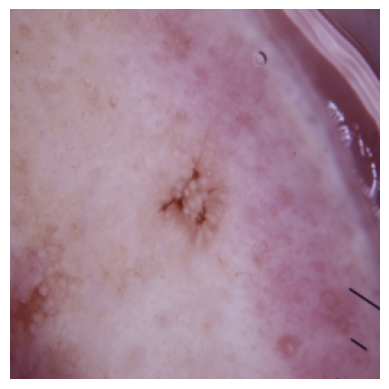

Clinical Data:
    Age Dx Type     Sex Localization
0  55.0          Female      Genital

Prediction Probabilities:
Benign lesions of the keratosis: 0.0002
Basal cell carcinoma: 0.0000
Dermatofibroma: 0.0000
Melanoma: 0.0000
Melanocytic nevi: 0.0000
Vascular lesions: 0.0000
Actinic keratoses: 0.9998

Actual Class: Actinic keratoses
Predicted Class: Actinic keratoses


In [ ]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Select a random index from the test set
random_idx = np.random.randint(0, len(test_dataset))

# Get the sample
sample = test_dataset[random_idx]

# Get the image and clinical data
image = sample['image'].unsqueeze(0).to(device)  # Add batch dimension
clinical_data = sample['clinical_data'].unsqueeze(0).to(device)  # Add batch dimension
actual_label = sample['label']

# Get the clinical data as a DataFrame (for better display)
clinical_data_dict = sample['clinical_data'].cpu().numpy()

# Determine the dx_type based on the columns 'dx_type_confocal', 'dx_type_consensus', and 'dx_type_follow_up'
dx_type = ''
if clinical_data_dict[0] == 1:
    dx_type = 'Confocal'
elif clinical_data_dict[1] == 1:
    dx_type = 'Consensus'
elif clinical_data_dict[2] == 1:
    dx_type = 'Follow-up'

# Determine the sex based on the 'sex_female' and 'sex_male' columns
sex = ''
if clinical_data_dict[4] == 1:
    sex = 'Female'
elif clinical_data_dict[5] == 1:
    sex = 'Male'
else:
    sex = 'Unknown'

# Determine the localization (only the body part where lesion is located is shown)
localization = []
local_columns = [
    'local_abdomen', 'local_acral', 'local_back', 'local_chest', 'local_ear', 'local_face', 'local_foot',
    'local_genital', 'local_hand', 'local_lower extremity', 'local_neck', 'local_scalp', 'local_trunk',
    'local_unknown', 'local_upper extremity'
]
for i, loc in enumerate(local_columns):
    if clinical_data_dict[i + 6] == 1:  # Skip the first 6 columns for dx_type and sex
        localization.append(loc.replace('local_', '').replace('_', ' ').capitalize())

# Create the DataFrame
clinical_df = pd.DataFrame([{
    'Age': clinical_data_dict[0],
    'Dx Type': dx_type,
    'Sex': sex,
    'Localization': ', '.join(localization) if localization else 'Unknown'
}], columns=['Age', 'Dx Type', 'Sex', 'Localization'])

# Get the prediction from the combined model
combined_model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    output = combined_model(image, clinical_data)

# Get the probabilities of each class
probs = torch.softmax(output, dim=1).cpu().numpy().flatten()

# Define the class names based on your dataset
class_names = [
    'Benign lesions of the keratosis', 
    'Basal cell carcinoma', 
    'Dermatofibroma', 
    'Melanoma', 
    'Melanocytic nevi', 
    'Vascular lesions', 
    'Actinic keratoses'
]

# Get the predicted class
predicted_class = np.argmax(probs)

# Plot the image
plt.imshow(sample['image'].permute(1, 2, 0))  # Change from [C, H, W] to [H, W, C]
plt.axis('off')  # Hide axes
plt.show()

# Display the clinical data
print("Clinical Data:")
print(clinical_df)

# Display the prediction probabilities for each class
print("\nPrediction Probabilities:")
for idx, class_name in enumerate(class_names):
    print(f"{class_name}: {probs[idx]:.4f}")

# Display the actual class and predicted class
print("\nActual Class:", class_names[actual_label])
print("Predicted Class:", class_names[predicted_class])


In [ ]:
clinical_df

Age Dx Type     Sex Localization
0  55.0          Female      Genital

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch.nn.functional as F
import seaborn as sns
import pandas as pd

class ModelVisualizer:
    def __init__(self, model_path, device='cuda'):
        self.device = device
        self.model = torch.load(model_path).to(device)
        self.model.eval()
        
        # Define clinical feature names
        self.clinical_feature_names = [
            "Age",
            "Dx Type: Confocal",
            "Dx Type: Consensus",
            "Dx Type: Follow-Up",
            "Dx Type: Histopathology",
            "Sex: Female",
            "Sex: Male",
            "Sex: Unknown",
            "Localization: Abdomen",
            "Localization: Acral",
            "Localization: Back",
            "Localization: Chest",
            "Localization: Ear",
            "Localization: Face",
            "Localization: Foot",
            "Localization: Genital",
            "Localization: Hand",
            "Localization: Lower Extremity",
            "Localization: Neck",
            "Localization: Scalp",
            "Localization: Trunk",
            "Localization: Unknown",
            "Localization: Upper Extremity"
        ]
        
    def generate_gradcam(self, image, clinical_data, target_layer_name='conv5'):
        """
        Generate smooth Grad-CAM visualization for the image pathway
        """
        # Register hooks for the target layer
        activation = None
        gradients = None
        
        def save_activation(module, input, output):
            nonlocal activation
            activation = output
            
        def save_gradient(module, grad_input, grad_output):
            nonlocal gradients
            gradients = grad_output[0]
        
        # Find target layer
        target_layer = None
        for name, module in self.model.image_model.named_modules():
            if name == target_layer_name:
                target_layer = module
                break
                
        if target_layer is None:
            raise ValueError(f"Layer {target_layer_name} not found")
            
        # Register hooks
        handle1 = target_layer.register_forward_hook(save_activation)
        handle2 = target_layer.register_backward_hook(save_gradient)
        
        # Forward pass
        image_tensor = image.unsqueeze(0).to(self.device)
        clinical_tensor = torch.tensor(clinical_data, dtype=torch.float32).unsqueeze(0).to(self.device)
        
        output = self.model(image_tensor, clinical_tensor)
        pred = output.argmax(dim=1)
        
        # Backward pass
        self.model.zero_grad()
        output[0, pred].backward()
        
        # Remove hooks
        handle1.remove()
        handle2.remove()
        
        # Generate CAM
        weights = gradients.mean(dim=(2, 3))
        cam = (weights.unsqueeze(-1).unsqueeze(-1) * activation).sum(dim=1)
        cam = F.relu(cam)
        
        # Normalize and resize
        cam = F.interpolate(cam.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False)
        cam = cam.squeeze().cpu().detach().numpy()
        
        # Apply Gaussian blur for smoothness
        cam = cv2.GaussianBlur(cam, (15, 15), 10)
        
        # Normalize to [0, 1]
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        
        return cam
    
    def generate_clinical_importance(self, image, clinical_data, baseline=None):
        """
        Generate instance-specific feature importance using integrated gradients
        
        Args:
            image (torch.Tensor): Input image tensor
            clinical_data (torch.Tensor): Input clinical data tensor
            baseline (torch.Tensor, optional): Baseline input for comparison
        
        Returns:
            numpy.ndarray: Feature importance scores
        """
        # Prepare inputs
        image_tensor = image.unsqueeze(0).to(self.device)
        clinical_tensor = torch.tensor(clinical_data, dtype=torch.float32).unsqueeze(0).to(self.device)
        
        # Create baseline if not provided (use zeros or mean of training data)
        if baseline is None:
            baseline_clinical = torch.zeros_like(clinical_tensor)
        else:
            baseline_clinical = baseline.unsqueeze(0).to(self.device)
        
        # Number of steps for integrated gradients
        steps = 50
        
        # Initialize accumulator for integrated gradients
        integrated_grads = torch.zeros_like(clinical_tensor)
        
        # Compute integrated gradients
        for alpha in torch.linspace(0, 1, steps):
            # Interpolate between baseline and actual input
            interpolated_clinical = baseline_clinical + alpha * (clinical_tensor - baseline_clinical)
            interpolated_clinical.requires_grad_(True)
            
            # Forward pass
            output = self.model(image_tensor, interpolated_clinical)
            pred_class = output.argmax(dim=1)
            
            # Backward pass
            self.model.zero_grad()
            output[0, pred_class].backward()
            
            # Accumulate gradients
            integrated_grads += interpolated_clinical.grad
        
        # Average the gradients
        integrated_grads /= steps
        
        # Compute feature importance (absolute values)
        importance = torch.abs(integrated_grads).squeeze().cpu().detach().numpy()
        
        # Normalize importance scores
        importance = (importance - importance.min()) / (importance.max() - importance.min() + 1e-8)
        
        return importance
    
    def visualize(self, image, clinical_data, class_names):
        """
        Updated visualization method to use instance-specific feature importance
        """
        # Generate attributions
        cam = self.generate_gradcam(image, clinical_data)
        clinical_importance = self.generate_clinical_importance(image, clinical_data)
        
        # Create visualization
        fig = plt.figure(figsize=(20, 12))
        
        # Plot original image
        ax1 = plt.subplot(2, 2, 1)
        plt.imshow(image.permute(1, 2, 0).cpu())
        plt.title('Original Image', fontsize=12, pad=10)
        plt.axis('off')
        
        # Plot Grad-CAM
        ax2 = plt.subplot(2, 2, 2)
        plt.imshow(image.permute(1, 2, 0).cpu())
        plt.imshow(cam, cmap='jet', alpha=0.5)
        plt.title('Grad-CAM Visualization', fontsize=12, pad=10)
        plt.axis('off')
        
        # Plot clinical feature importance
        ax3 = plt.subplot(2, 1, 2)
        importance_df = pd.DataFrame({
            'Feature': self.clinical_feature_names,
            'Importance': clinical_importance
        })
        importance_df = importance_df.sort_values('Importance', ascending=True)
        
        sns.barplot(data=importance_df, y='Feature', x='Importance', 
                   palette='viridis', ax=ax3)
        plt.title('Instance-Specific Clinical Feature Importance', fontsize=12, pad=10)
        
        # Adjust layout for better readability
        ax3.set_xlabel('Relative Importance', fontsize=10)
        ax3.set_ylabel('Clinical Features', fontsize=10)
        ax3.tick_params(axis='both', which='major', labelsize=8)
        
        plt.tight_layout()
        return fig
    
    def get_prediction(self, image, clinical_data):
        """
        Get model prediction and confidence
        """
        with torch.no_grad():
            image_tensor = image.unsqueeze(0).to(self.device)
            clinical_tensor = torch.tensor(clinical_data, 
                                        dtype=torch.float32).unsqueeze(0).to(self.device)
            
            output = self.model(image_tensor, clinical_tensor)
            probabilities = F.softmax(output, dim=1)
            
            pred_class = torch.argmax(probabilities).item()
            confidence = probabilities[0][pred_class].item()
            
        return pred_class, confidence

def plot_sample_predictions(visualizer, test_loader, class_names, num_samples=5):
    """
    Plot sample predictions with visualizations
    """
    samples = []
    for batch in test_loader:
        if len(samples) >= num_samples:
            break
        samples.extend([(batch['image'][i], 
                        batch['clinical_data'][i], 
                        batch['label'][i]) 
                       for i in range(len(batch['label']))])
    
    samples = samples[:num_samples]
    
    for image, clinical_data, true_label in samples:
        pred_class, confidence = visualizer.get_prediction(image, clinical_data)
        
        fig = visualizer.visualize(image, clinical_data, class_names)
        
        plt.suptitle(f'True: {class_names[true_label]}\n' \
                    f'Predicted: {class_names[pred_class]} ' \
                    f'(Confidence: {confidence:.2f})', 
                    y=1.02, fontsize=14)
        plt.show()

C:\Users\dasad\AppData\Local\Temp\ipykernel_16304\301255111.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model = torch.load(model_path).to(device)
C:\Users\dasa

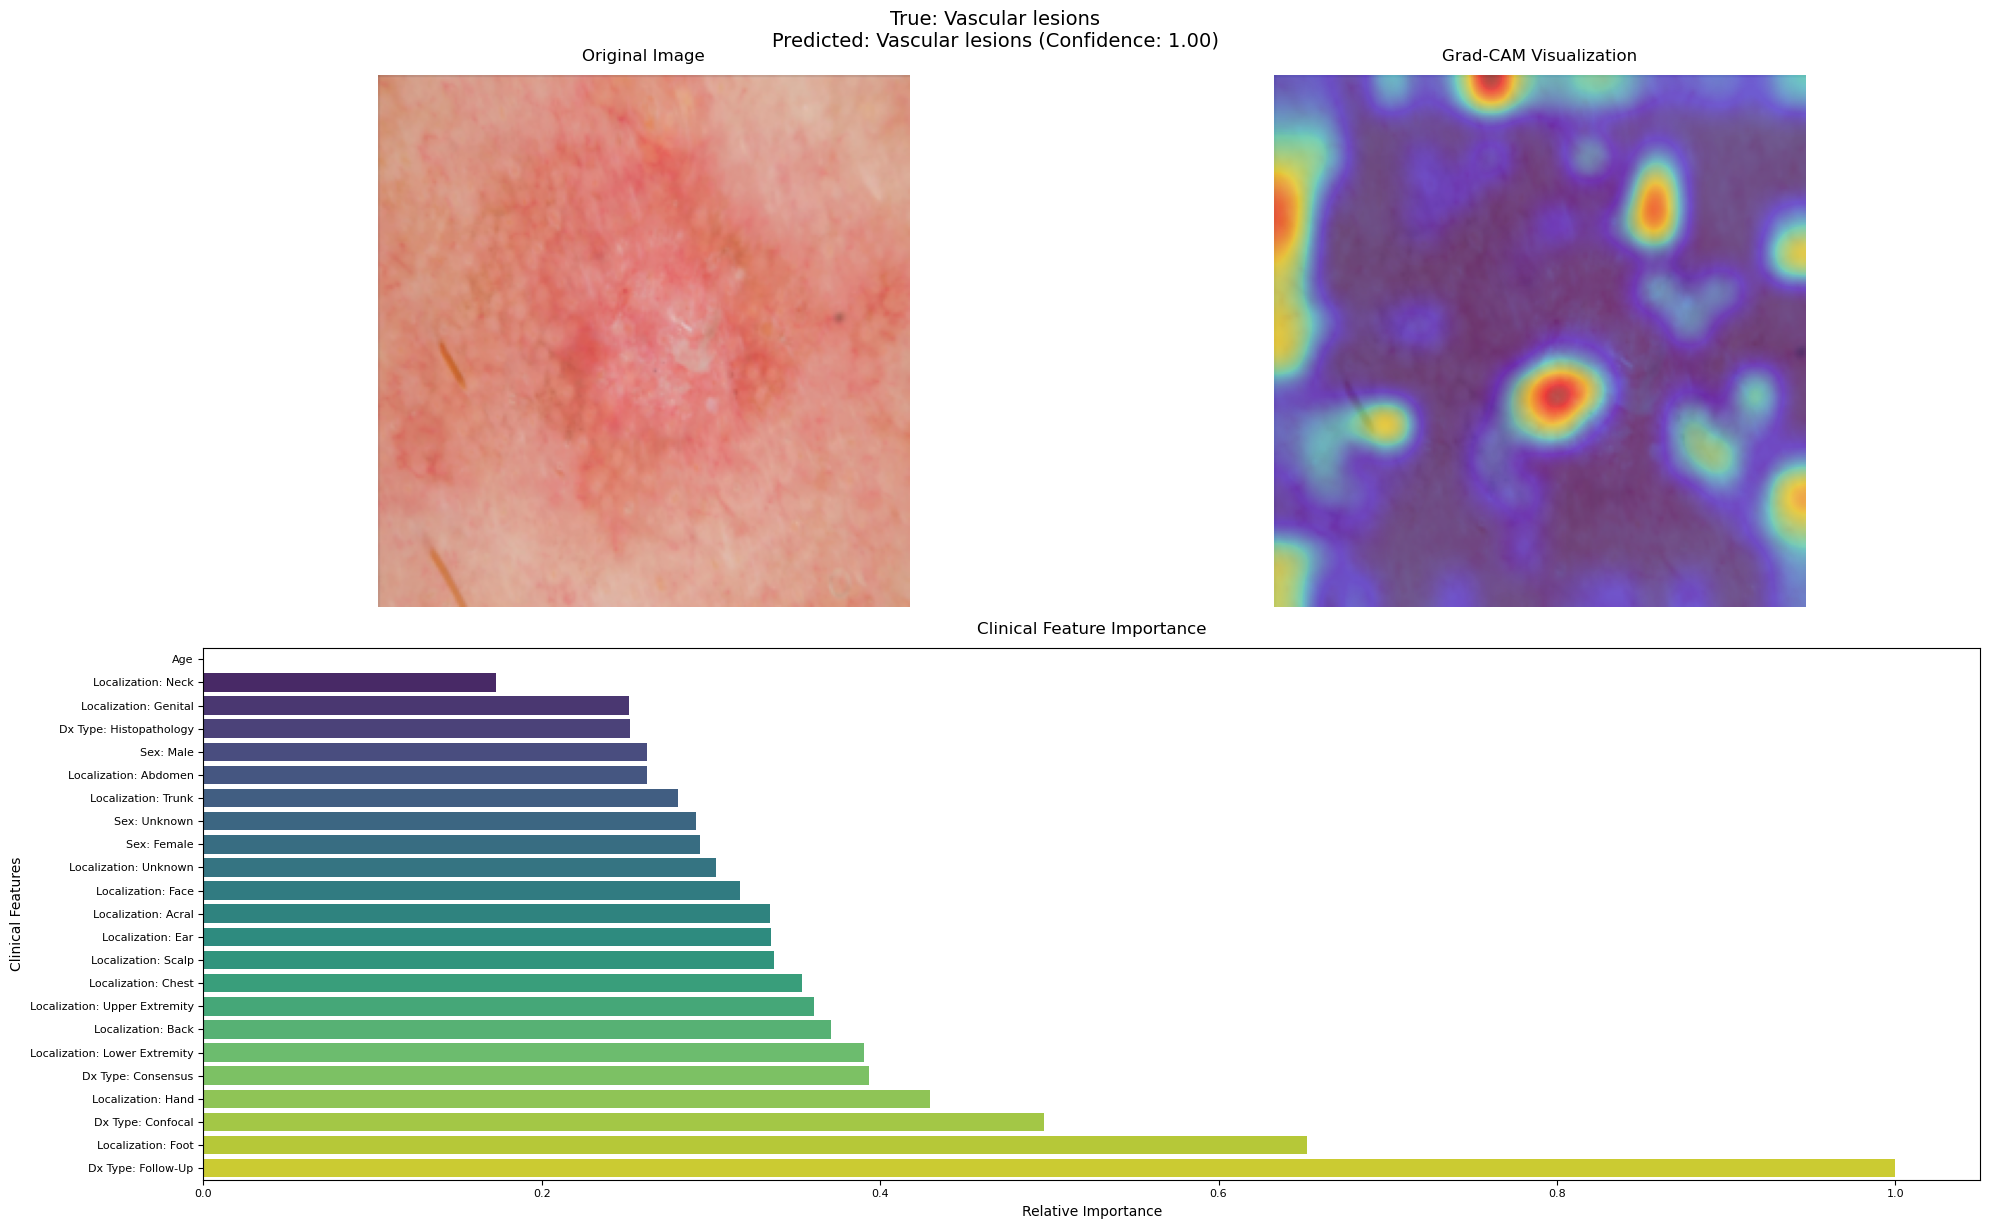

C:\Users\dasad\AppData\Local\Temp\ipykernel_16304\301255111.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clinical_tensor = torch.tensor(clinical_data,
C:\Users\dasad\AppData\Local\Temp\ipykernel_16304\301255111.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clinical_tensor = torch.tensor(clinical_data, dtype=torch.float32).unsqueeze(0).to(self.device)
C:\Users\dasad\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook 

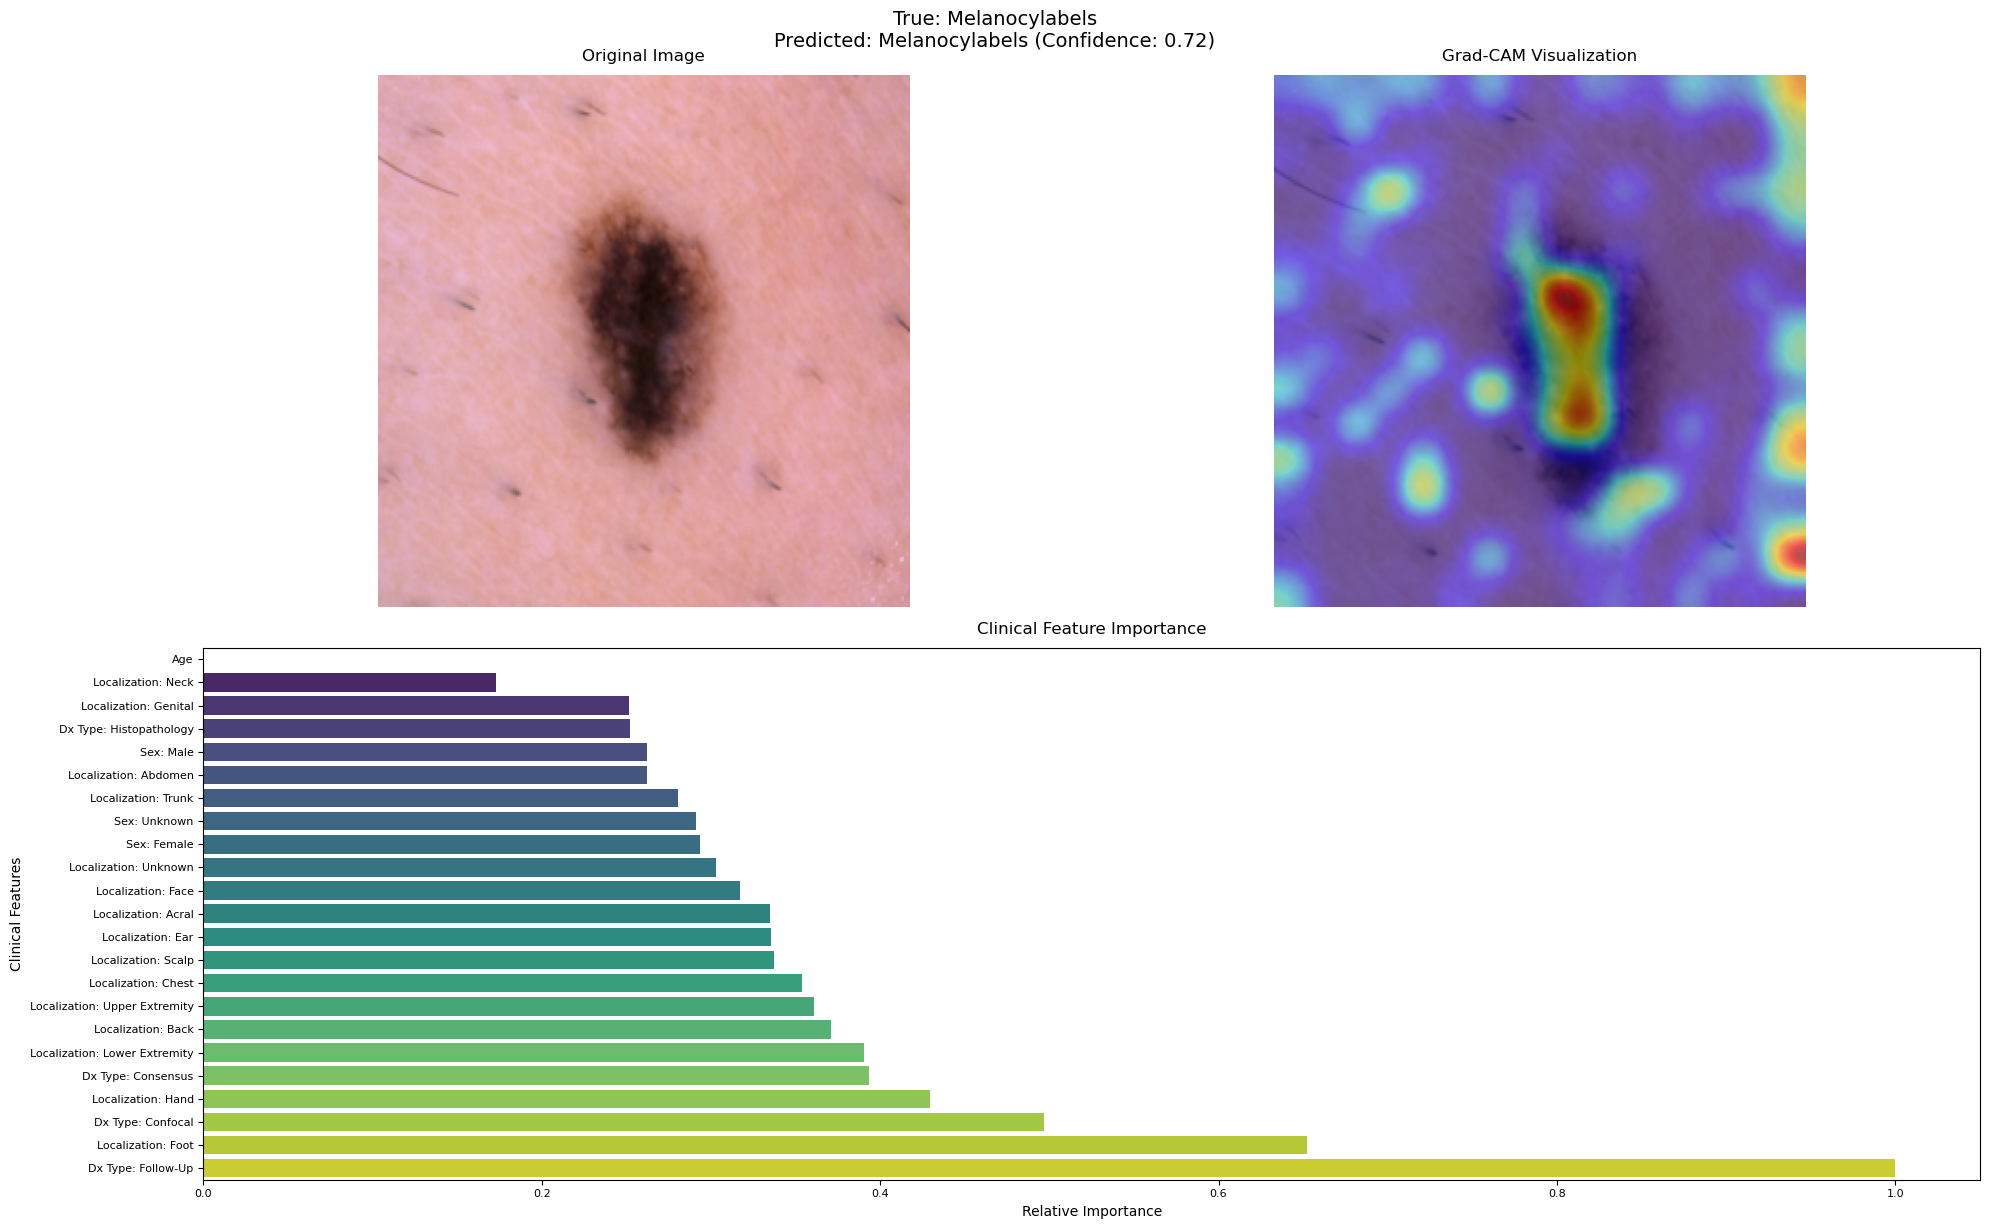

C:\Users\dasad\AppData\Local\Temp\ipykernel_16304\301255111.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clinical_tensor = torch.tensor(clinical_data,
C:\Users\dasad\AppData\Local\Temp\ipykernel_16304\301255111.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clinical_tensor = torch.tensor(clinical_data, dtype=torch.float32).unsqueeze(0).to(self.device)
C:\Users\dasad\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook 

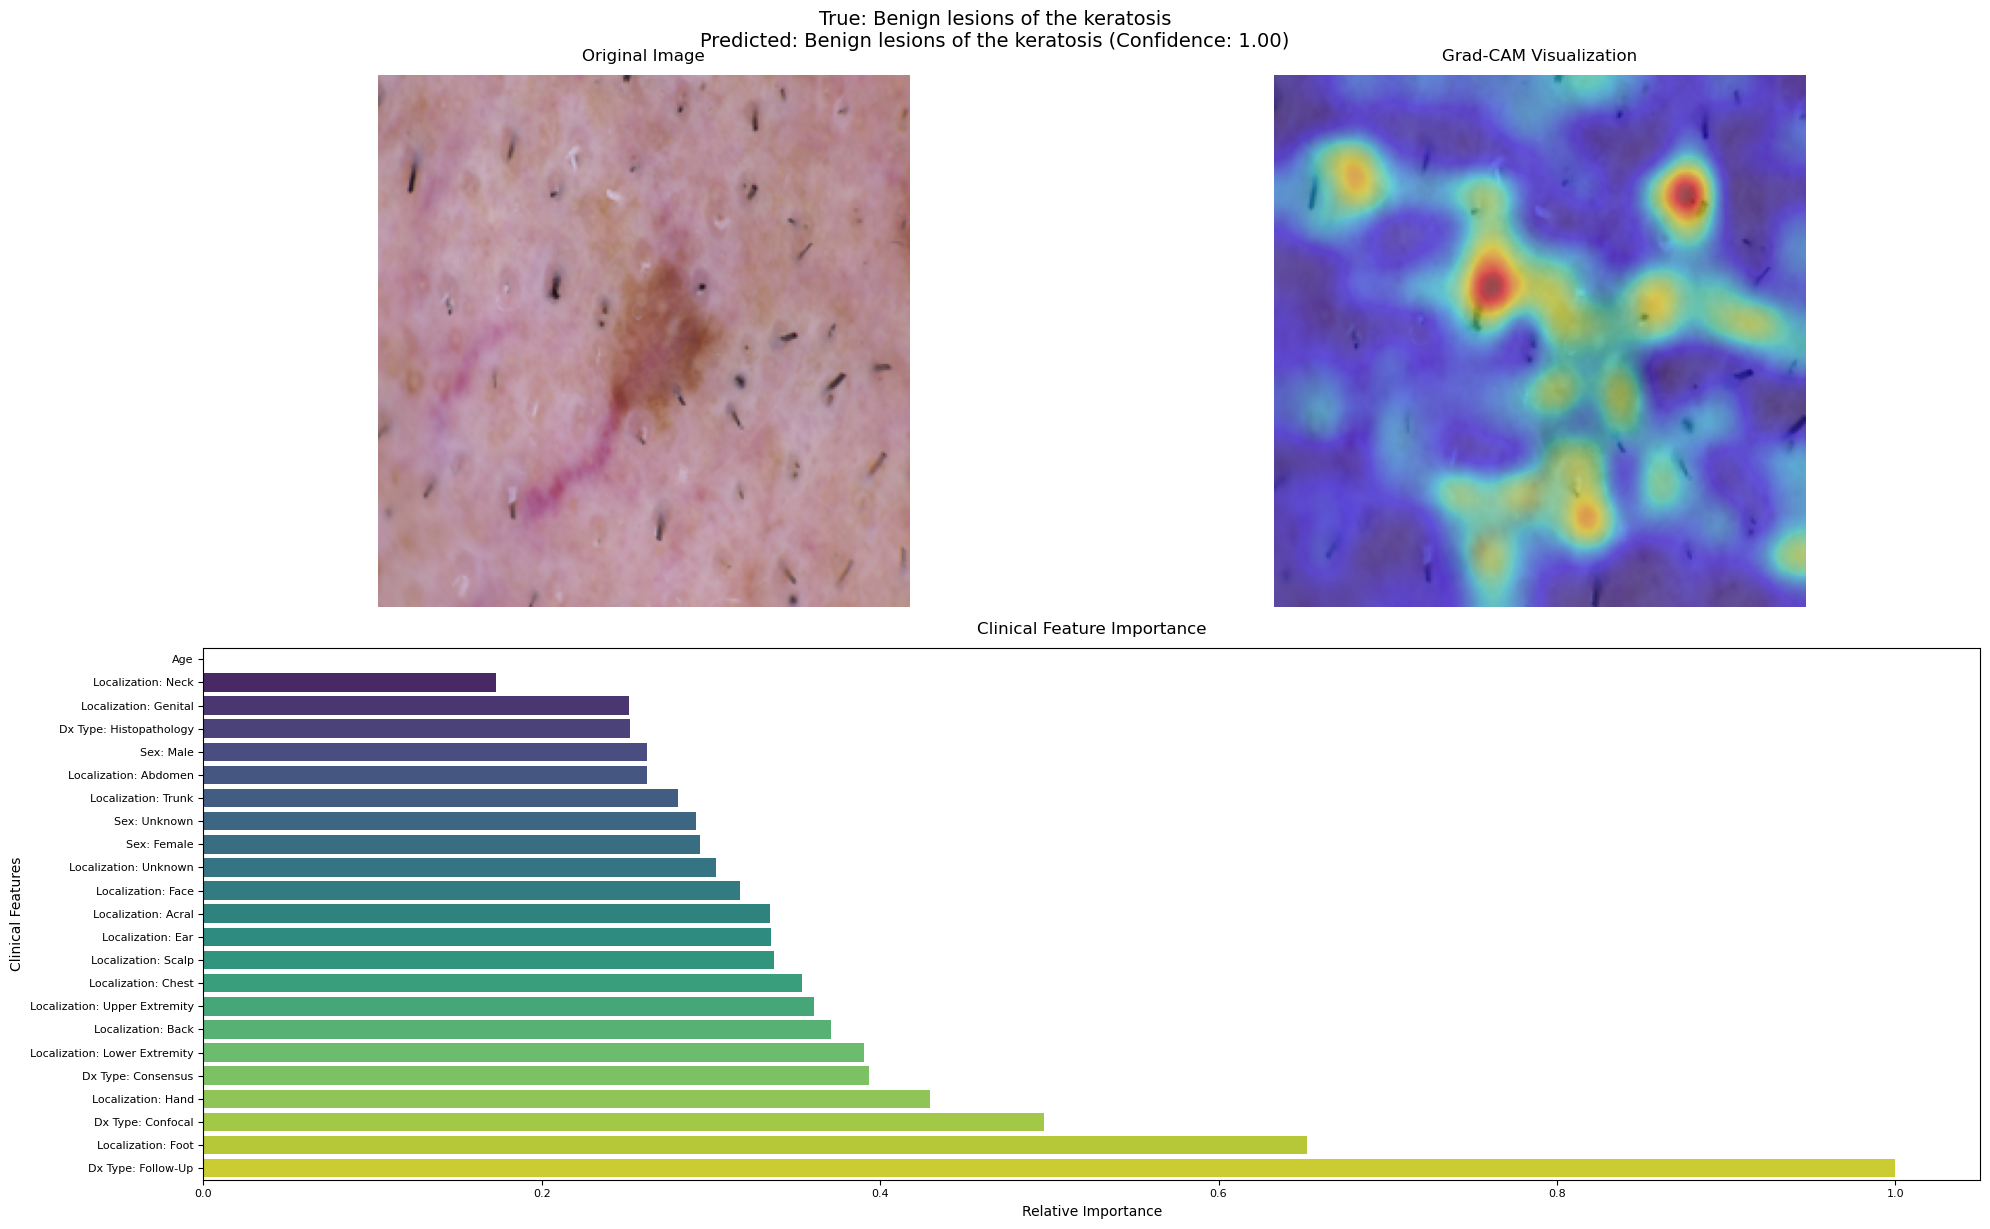

C:\Users\dasad\AppData\Local\Temp\ipykernel_16304\301255111.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clinical_tensor = torch.tensor(clinical_data,
C:\Users\dasad\AppData\Local\Temp\ipykernel_16304\301255111.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clinical_tensor = torch.tensor(clinical_data, dtype=torch.float32).unsqueeze(0).to(self.device)
C:\Users\dasad\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook 

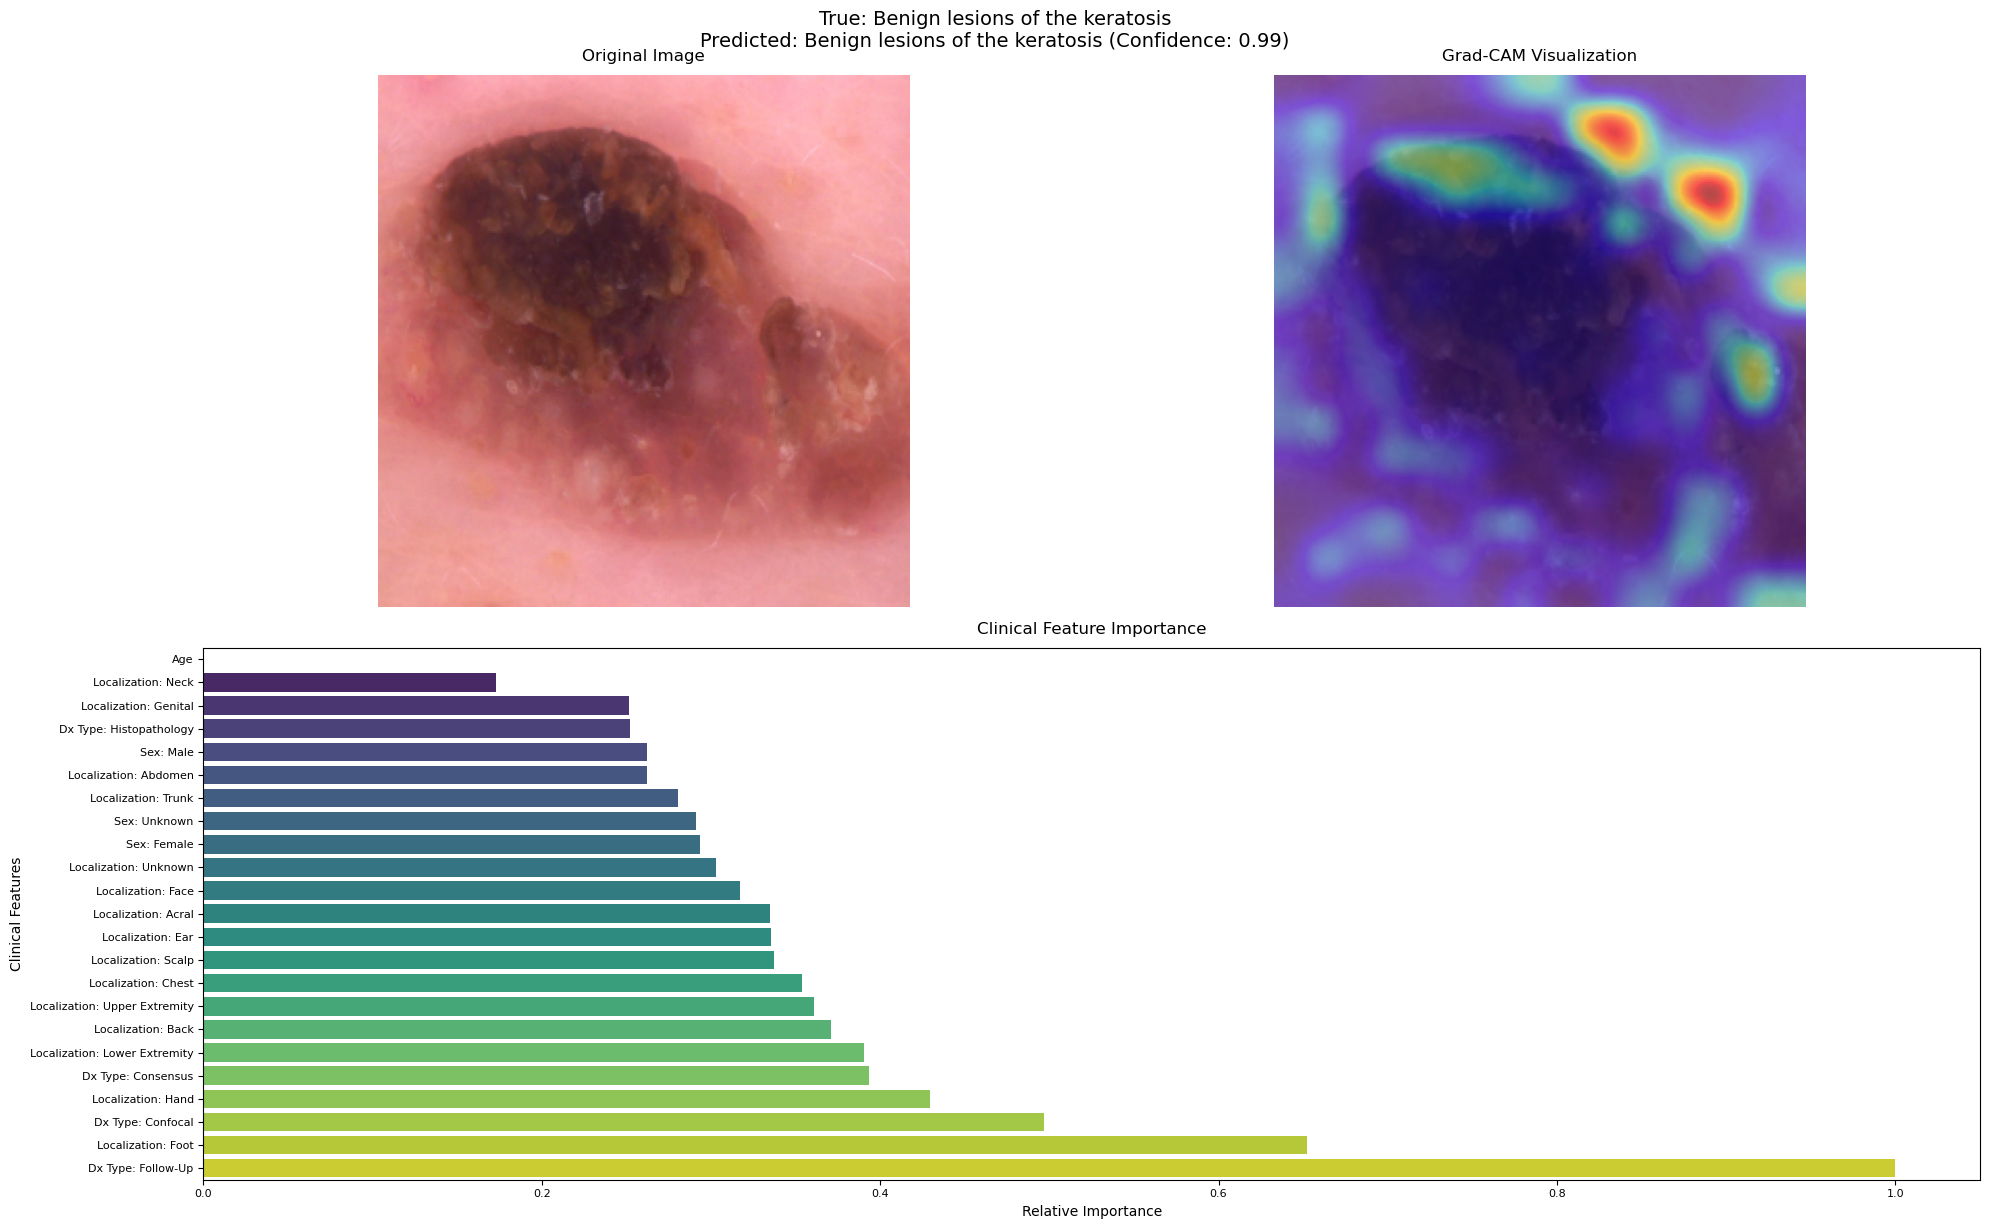

C:\Users\dasad\AppData\Local\Temp\ipykernel_16304\301255111.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clinical_tensor = torch.tensor(clinical_data,
C:\Users\dasad\AppData\Local\Temp\ipykernel_16304\301255111.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clinical_tensor = torch.tensor(clinical_data, dtype=torch.float32).unsqueeze(0).to(self.device)
C:\Users\dasad\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook 

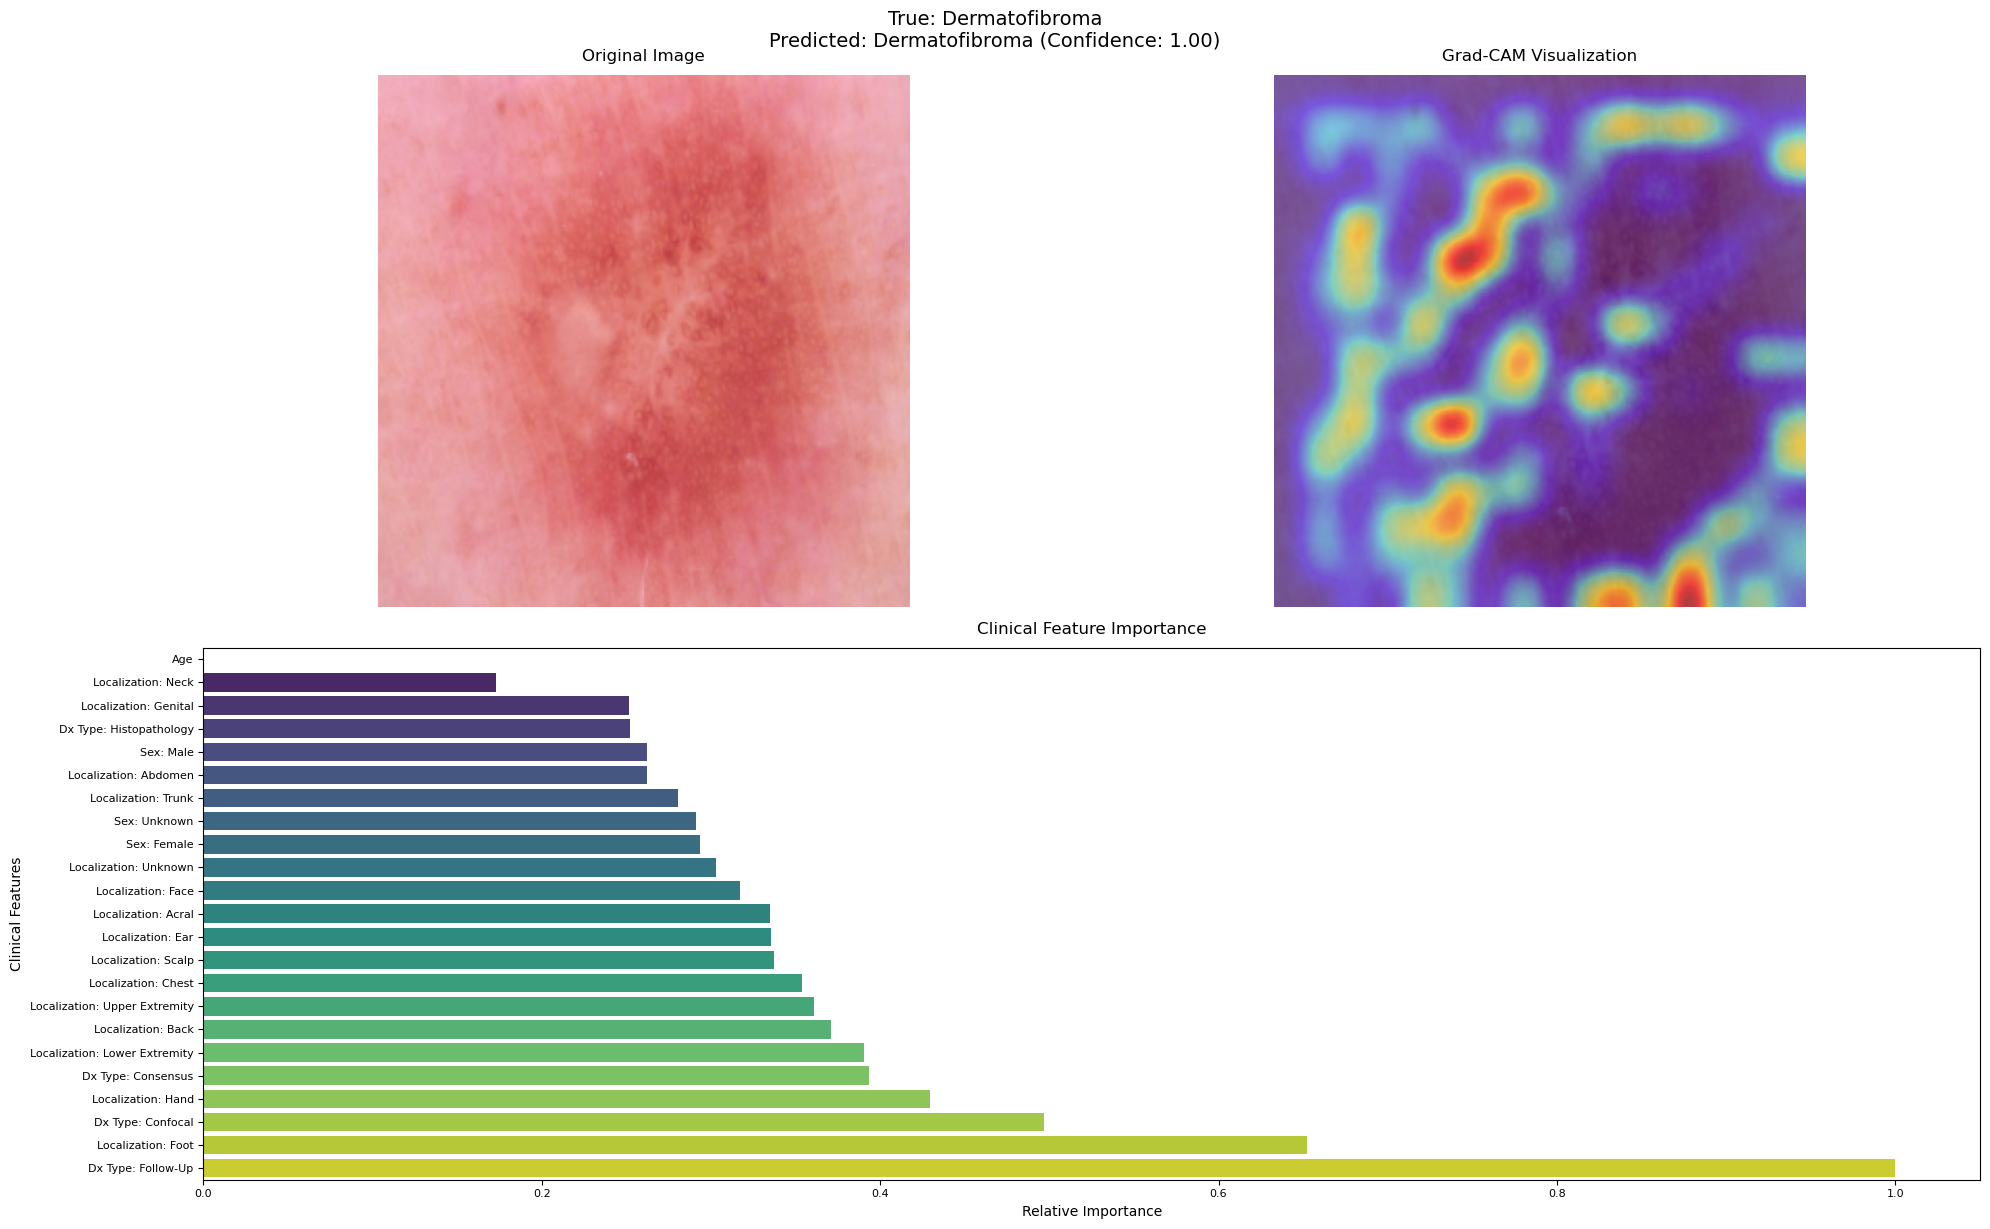

In [ ]:
# Initialize the visualizer
visualizer = ModelVisualizer("FinalWeights/CrossAttentionFusion.pt")

# Generate visualizations for sample predictions
plot_sample_predictions(visualizer, test_loader, classnames)

Original Classnames:
0: Benign lesions of the keratosis
1: Basal cell carcinoma
2: Dermatofibroma
3: Melanoma
4: Melanocylabels
5: tic nevi
6: Vascular lesions
7: Actinic keratoses


C:\Users\dasad\AppData\Local\Temp\ipykernel_16304\2580716527.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load("FinalWeights/CrossAttentionFusio

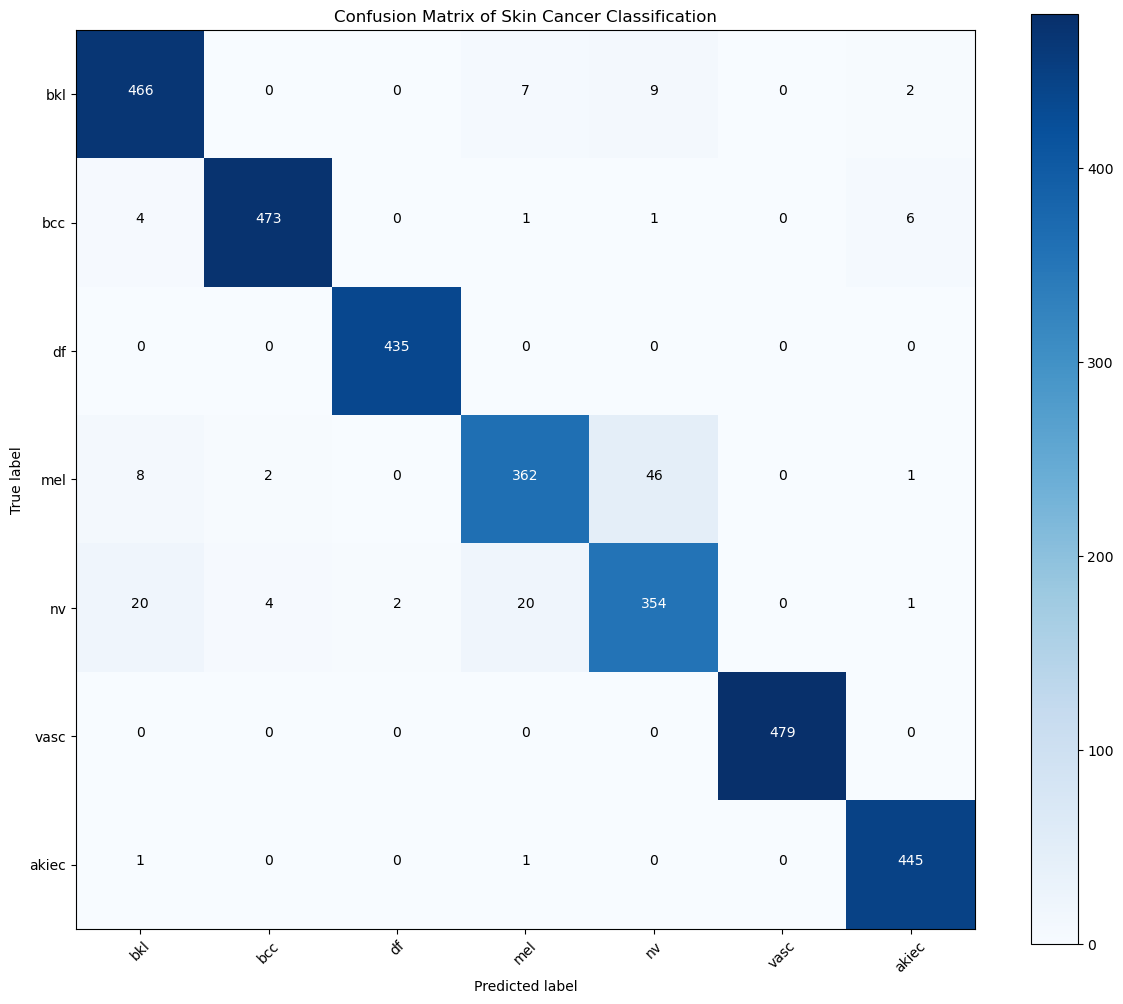

Test Data Classification Report:
               precision    recall  f1-score   support

         bkl     0.9339    0.9628    0.9481       484
         bcc     0.9875    0.9753    0.9813       485
          df     0.9954    1.0000    0.9977       435
         mel     0.9258    0.8640    0.8938       419
          nv     0.8634    0.8828    0.8730       401
        vasc     1.0000    1.0000    1.0000       479
       akiec     0.9780    0.9955    0.9867       447

    accuracy                         0.9568      3150
   macro avg     0.9549    0.9543    0.9544      3150
weighted avg     0.9569    0.9568    0.9567      3150


Training Data Classification Report:
               precision    recall  f1-score   support

         bkl     0.9679    0.9952    0.9814      2516
         bcc     0.9988    0.9920    0.9954      2515
          df     0.9996    1.0000    0.9998      2565
         mel     0.9813    0.9349    0.9575      2581
          nv     0.9391    0.9677    0.9532      2599
     

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Print out the original classnames to verify
print("Original Classnames:")
for i, name in enumerate(classnames):
    print(f"{i}: {name}")

# Corrected label dictionary to match exact class names
label_dict = {
    "bkl": "Benign lesions of the keratosis",
    "bcc": "Basal cell carcinoma", 
    "df": "Dermatofibroma", 
    "mel": "Melanoma", 
    "nv": "Melanocytic nevi", 
    "vasc": "Vascular lesions", 
    "akiec": "Actinic keratoses"
}

# Reverse the dictionary for abbreviation lookup
abbrev_dict = {v: k for k, v in label_dict.items()}

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model = torch.load("FinalWeights/CrossAttentionFusion.pt").to(device)
loaded_model.eval()

# Prepare to collect predictions and true labels
all_preds = []
all_labels = []

# Collect predictions
with torch.no_grad():
    for batch in test_loader:
        images = batch["image"].to(device)
        clinical_data = batch["clinical_data"].to(device)
        labels = batch["label"].to(device)
        
        outputs = loaded_model(images, clinical_data)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Prepare class names and abbreviations
# Directly use the original classnames list
class_names = classnames
class_abbrevs = list(label_dict.keys())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix of Skin Cancer Classification')
plt.colorbar()

# Add text annotations
tick_marks = np.arange(len(class_abbrevs))
plt.xticks(tick_marks, class_abbrevs, rotation=45)
plt.yticks(tick_marks, class_abbrevs)

# Add text values in each cell
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Compute classification report
report = classification_report(
    all_labels, 
    all_preds, 
    target_names=class_abbrevs,
    digits=4
)
print("Test Data Classification Report:\n", report)

# Same for training data
train_preds = []
train_labels = []

with torch.no_grad():
    for batch in train_loader:
        images = batch["image"].to(device)
        clinical_data = batch["clinical_data"].to(device)
        labels = batch["label"].to(device)
        
        outputs = loaded_model(images, clinical_data)
        _, preds = torch.max(outputs, 1)
        
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
train_preds = np.array(train_preds)
train_labels = np.array(train_labels)

# Compute training classification report
train_report = classification_report(
    train_labels, 
    train_preds, 
    target_names=class_abbrevs,
    digits=4
)
print("\nTraining Data Classification Report:\n", train_report)